# A Cross-Regional Analysis of Precipitation Extremes and Agricultural Vulnerability (1981-2021)



## Project Setup

In [1]:
# google colab installs

!pip install --quiet s3fs boto3 botocore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 6.4 MB/s eta 0:00:00


In [2]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pooch
import os
import tempfile
import pandas as pd
import s3fs
import boto3
import botocore
import datetime

In [3]:
# @title Helper functions

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/Projects/Precipitation' # this is different for each day
    user_temp_cache=tempfile.gettempdir()

    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file

In [4]:
# @title Figure settings

import ipywidgets as widgets       # interactive display

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/neuromatch/climate-course-content/main/cma.mplstyle")

## CHIRPS Version 2.0 Global Daily 0.25°

The Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS) is a high-resolution precipitation dataset developed by the Climate Hazards Group at the University of California, Santa Barbara. It combines satellite-derived precipitation estimates with ground-based station data to provide gridded precipitation data at a quasi-global scale between 50°S-50°N.

Read more about CHIRPS here:

* [The climate hazards infrared precipitation with stations—a new environmental record for monitoring extremes](https://www.nature.com/articles/sdata201566)

* [Climate Hazard Group CHG Wiki](https://wiki.chc.ucsb.edu/CHIRPS_FAQ)

* [Data storage location](https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p25/)

In [5]:
def calculate_cdd_index(data):
    """
    This function takes a daily precipitation dataset as input and calculates
    the Consecutive Dry Days (CDD) index, which represents the longest sequence
    of consecutive days with precipitation less than 1mm. The input data should
    be a DataArray with time coordinates, and the function returns a DataArray
    with the CDD values for each unique year in the input data.
    Parameters:
    ----------
      - data (xarray.DataArray): The input daily precipitation data should be
      a dataset (eg. for chirps_data the DataArray would be chirps_data.precip)
    Returns:
    -------
      - cdd (xarray.DataArray): The calculated CDD index

    """
    # create a boolean array for dry days (PR < 1mm)
    dry_days = data < 1
    # initialize CDD array
    cdd = np.zeros(len(data.groupby("time.year")))
    # get unique years as a list
    unique_years = list(data.groupby("time.year").groups.keys())
    # iterate for each day
    for i, year in enumerate(unique_years):
        consecutive_trues = []
        current_count = 0
        for day in dry_days.sel(time=data["time.year"] == year).values:
            if day:
                current_count += 1
            else:
                if current_count > 0:
                    consecutive_trues.append(current_count)
                    current_count = 0
        if current_count > 0:
            consecutive_trues.append(current_count)
        # print(consecutive_trues)
        # CDD is the largest number of consecutive days
        cdd[i] = np.max(consecutive_trues)
    # transform to dataset
    cdd_da = xr.DataArray(cdd, coords={"year": unique_years}, dims="year")
    return cdd_da

In [6]:
# code to retrieve and load the data

years = range(1981,2024) # the years you want. we want 1981 till 2023
file_paths = ['https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/netcdf/p25/chirps-v2.0.' + str(year) + '.days_p25.nc' for year in years] # the format of the files
filenames = ['chirps-v2.0.'+str(year)+'.days_p25.nc' for year in years] # the format of the files

downloaded_files=[ pooch_load(fpath,fname) for (fpath,fname) in zip(file_paths,filenames)] # download all of the files

#### open data via xarray
chirps_data = xr.open_mfdataset(
    downloaded_files, combine="by_coords"
)  # open the files as one dataset

SHA256 hash of downloaded file: abf5aa47db1a47b1bb0358591d02adb7cdc765af1de83834aa0a36157828f0cb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 5264a039135cbe00fff7c2b8296123ddc652db67a3086ac1d84bc7cfd91d1b3c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 8083ed549a4027fddad74e4a3be75c8587ad0830de3be0200c56b295d81cbe26
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: e1c3edab18b4bd69a659a42e95ca9a97051b7055738fdf4b63796ff199bbf2a4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 795f

We can now visualize the content of the dataset.

In [7]:
# code to print the shape, array names, etc of the dataset
chirps_data

<xarray.Dataset> Size: 36GB
Dimensions:    (time: 15705, latitude: 400, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 2kB -49.88 -49.62 -49.38 ... 49.38 49.62 49.88
  * longitude  (longitude) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
  * time       (time) datetime64[ns] 126kB 1981-01-01 1981-01-02 ... 2023-12-31
Data variables:
    precip     (time, latitude, longitude) float32 36GB dask.array<chunksize=(61, 67, 240), meta=np.ndarray>
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-10-07
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

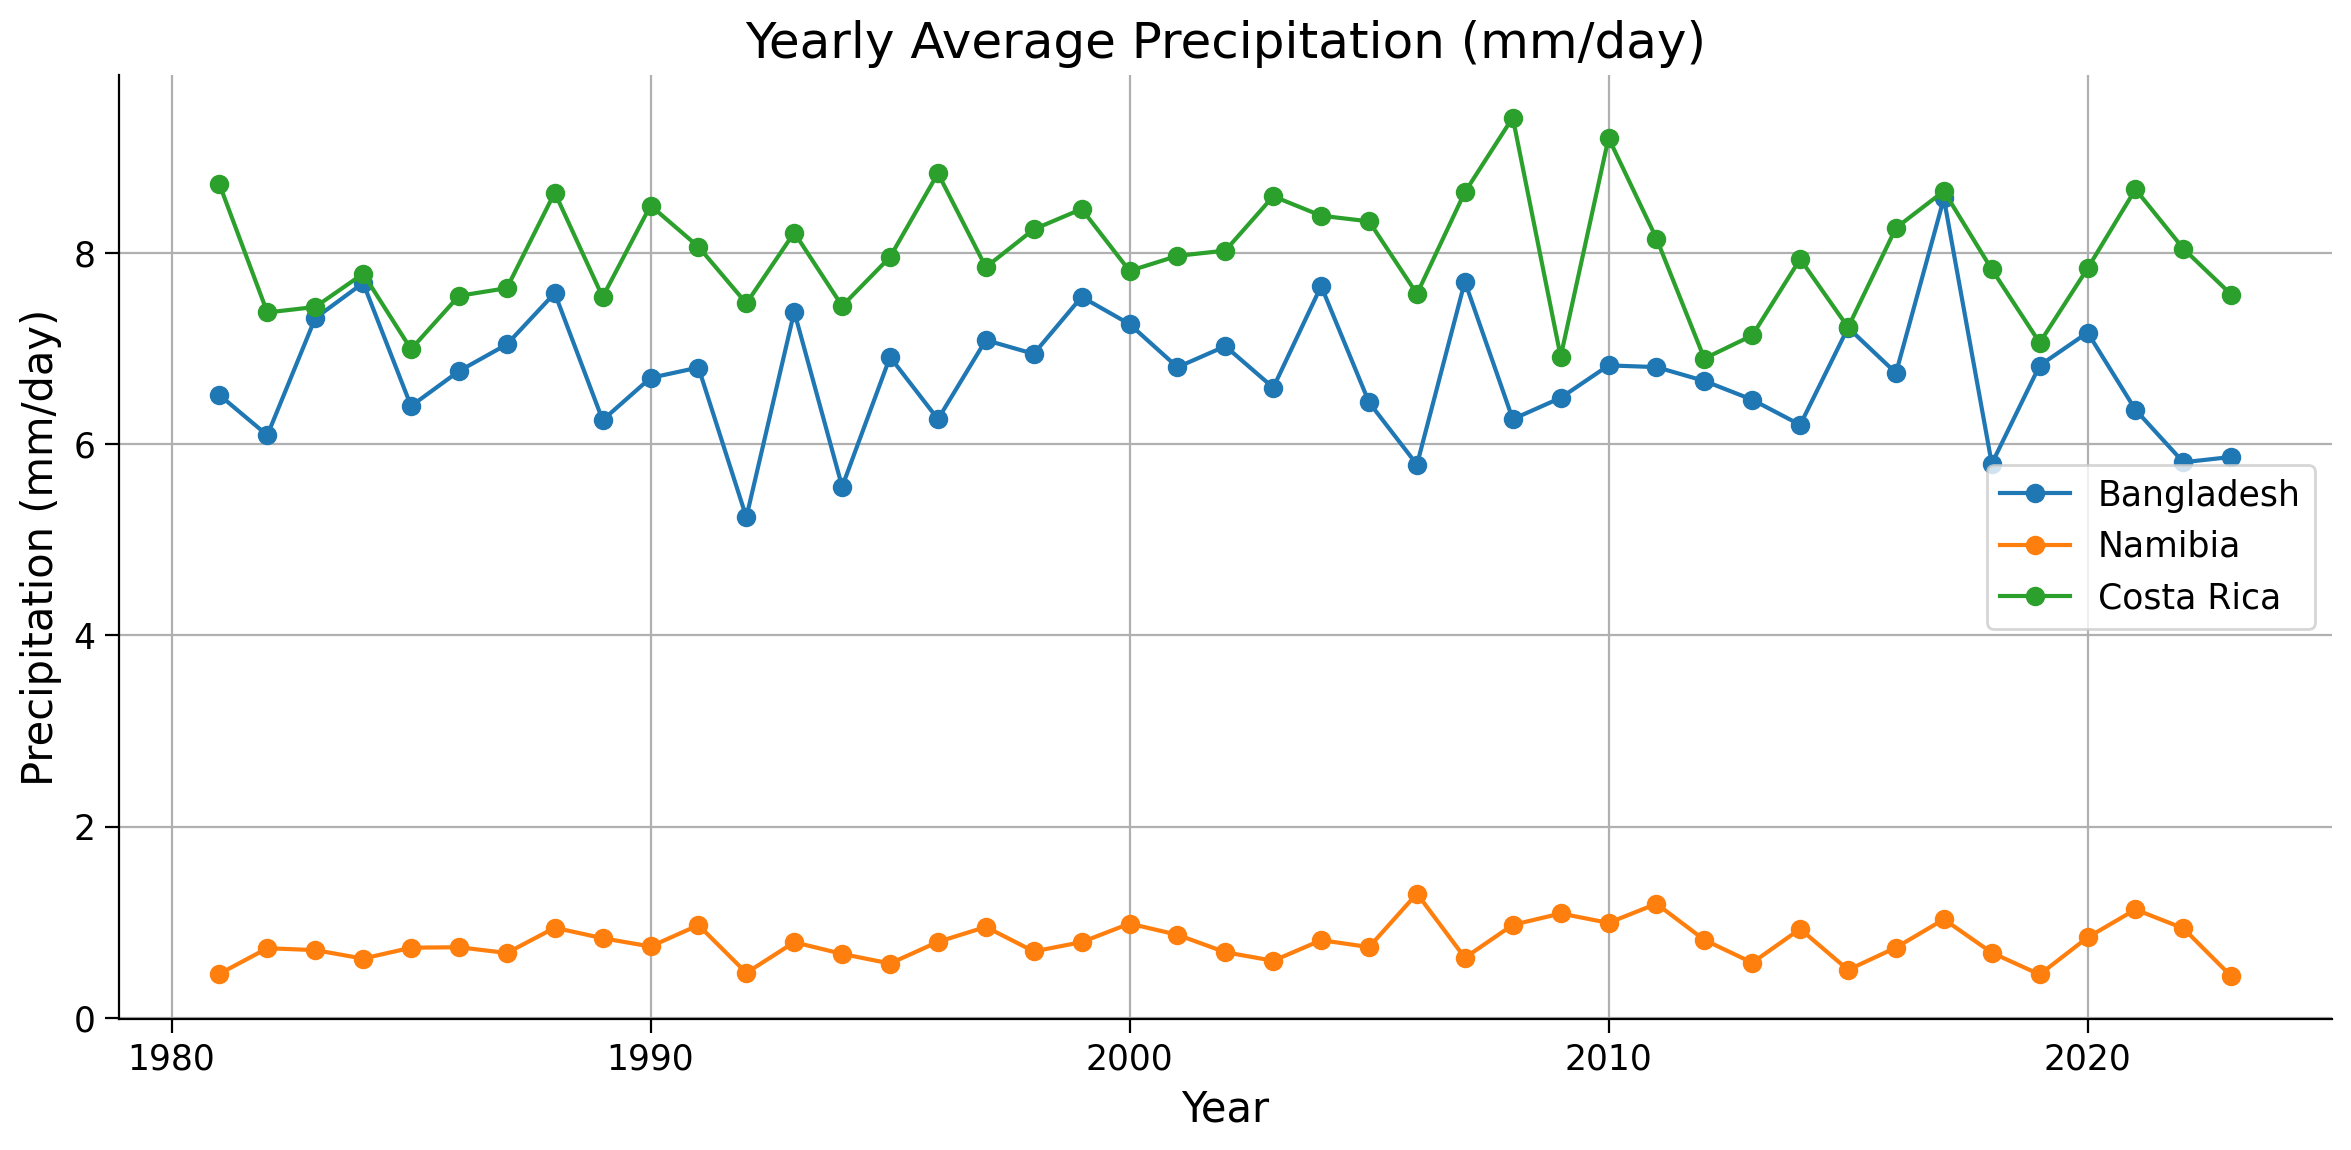

In [8]:
# Bangladesh
bangladesh_precip = chirps_data['precip'].sel(
    latitude=slice(20.5, 26.6),
    longitude=slice(88.0, 92.7)
).mean(dim=["latitude", "longitude"])

# Namibia
namibia_precip = chirps_data['precip'].sel(
    latitude=slice(-28.6, -17.5),
    longitude=slice(11.5, 25.3)
).mean(dim=["latitude", "longitude"])

# Costa Rica
costa_rica_precip = chirps_data['precip'].sel(
    latitude=slice(8.0, 11.5),
    longitude=slice(-85.9, -82.5)
).mean(dim=["latitude", "longitude"])

# Group by year
bangladesh_yearly = bangladesh_precip.groupby('time.year').mean()
namibia_yearly = namibia_precip.groupby('time.year').mean()
costa_rica_yearly = costa_rica_precip.groupby('time.year').mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(bangladesh_yearly['year'], bangladesh_yearly, label='Bangladesh', marker='o')
plt.plot(namibia_yearly['year'], namibia_yearly, label='Namibia', marker='o')
plt.plot(costa_rica_yearly['year'], costa_rica_yearly, label='Costa Rica', marker='o')

plt.title('Yearly Average Precipitation (mm/day)')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

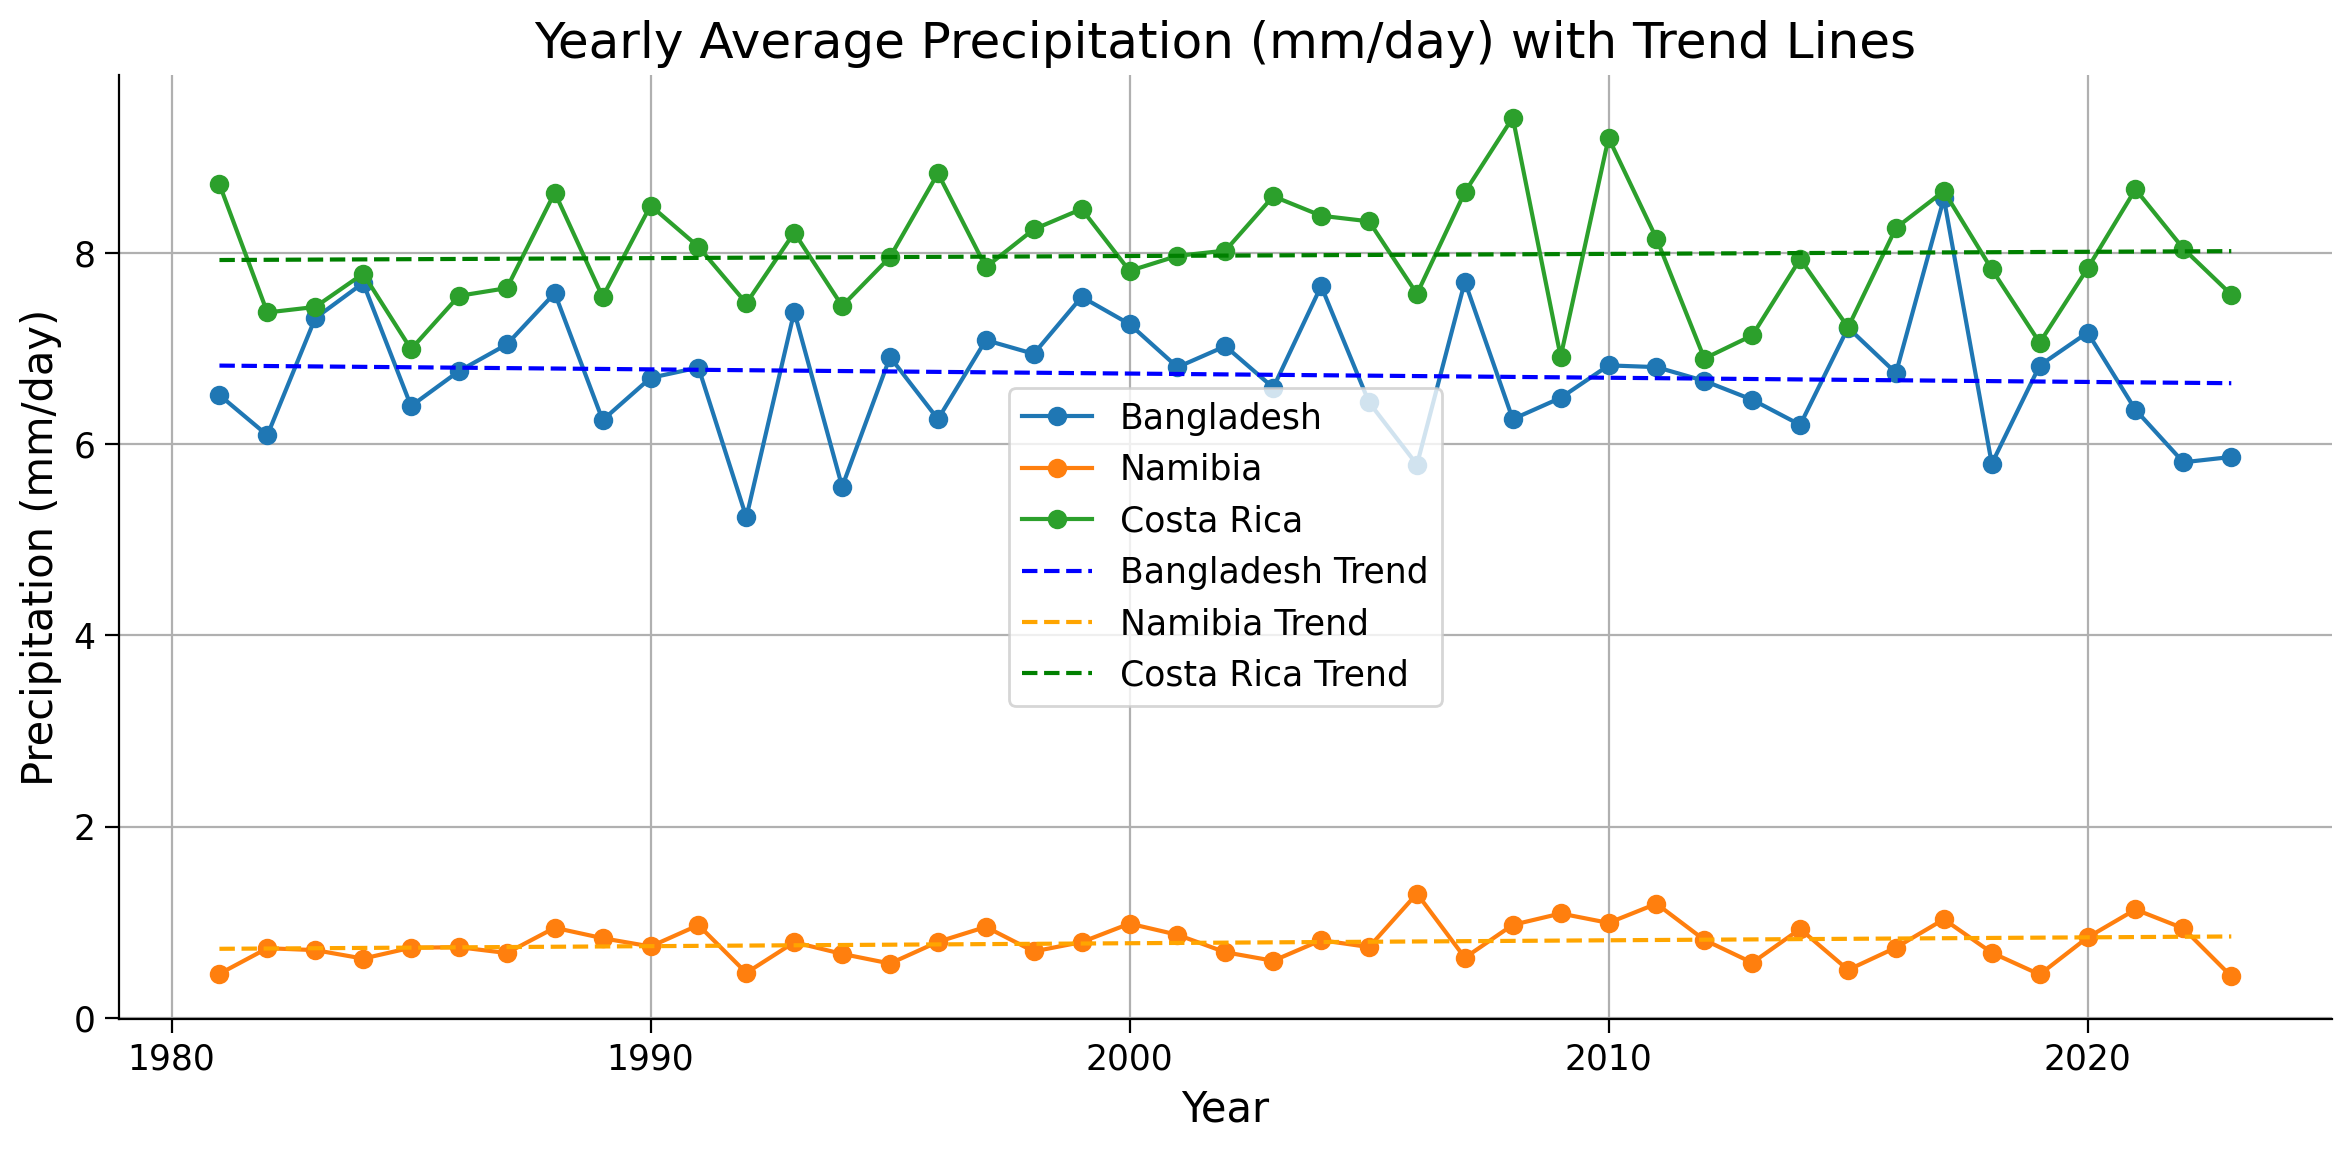

In [9]:
# Get years
years = bangladesh_yearly['year'].values

# Fit and evaluate trend lines
bangladesh_trend = np.polyval(np.polyfit(years, bangladesh_yearly.values, 1), years)
namibia_trend = np.polyval(np.polyfit(years, namibia_yearly.values, 1), years)
costa_rica_trend = np.polyval(np.polyfit(years, costa_rica_yearly.values, 1), years)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(years, bangladesh_yearly, label='Bangladesh', marker='o')
plt.plot(years, namibia_yearly, label='Namibia', marker='o')
plt.plot(years, costa_rica_yearly, label='Costa Rica', marker='o')

# Add regression (trend) lines
plt.plot(years, bangladesh_trend, label='Bangladesh Trend', linestyle='--', color='blue')
plt.plot(years, namibia_trend, label='Namibia Trend', linestyle='--', color='orange')
plt.plot(years, costa_rica_trend, label='Costa Rica Trend', linestyle='--', color='green')

plt.title('Yearly Average Precipitation (mm/day) with Trend Lines')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

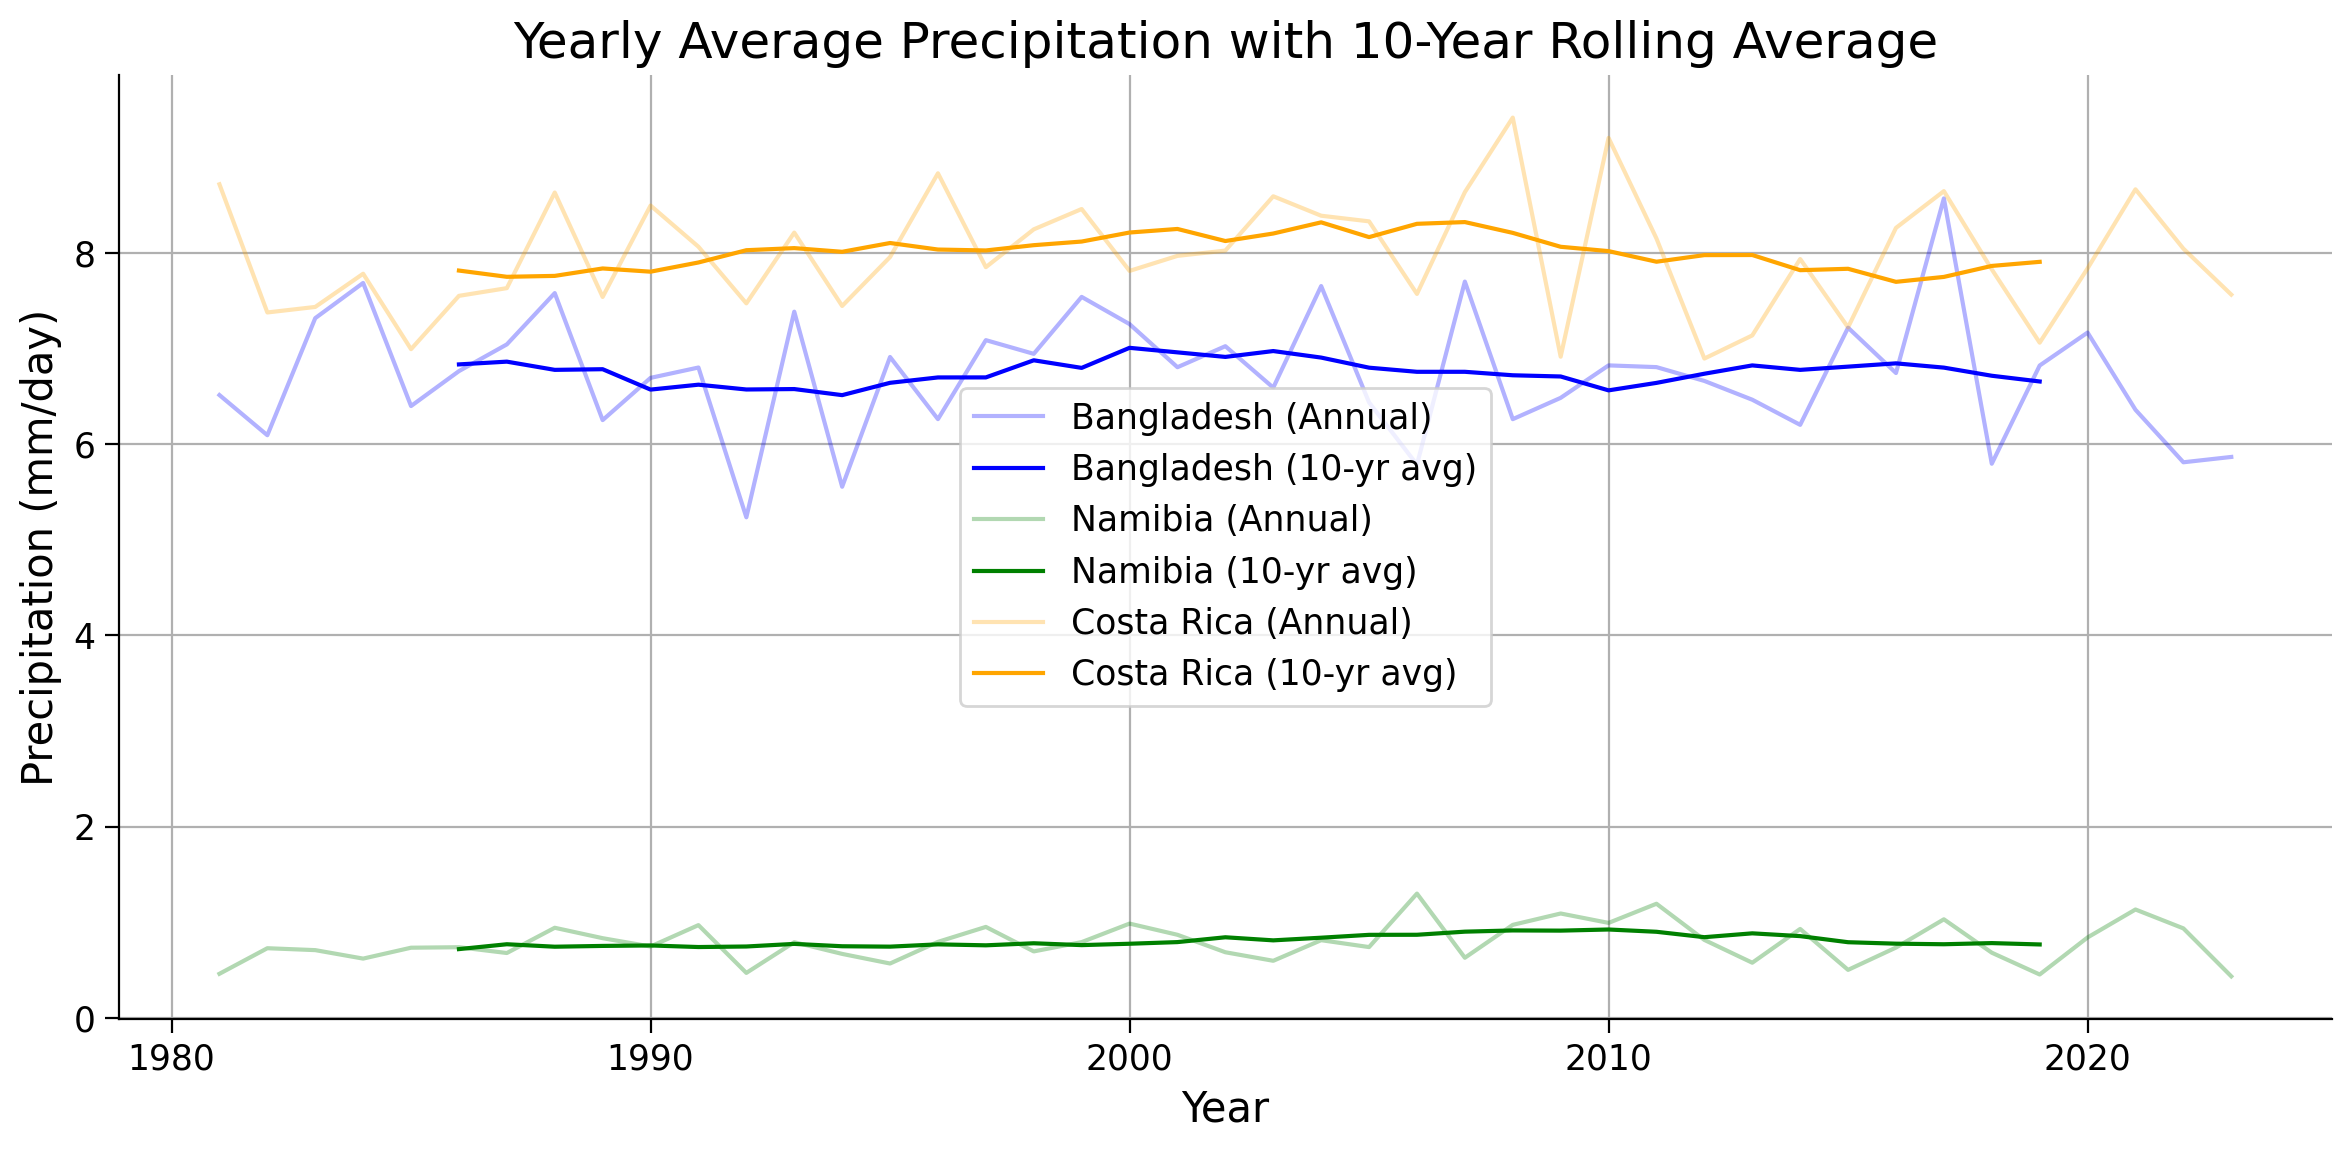

In [10]:
# Group by year
bangladesh_yearly = bangladesh_precip.groupby('time.year').mean()
namibia_yearly = namibia_precip.groupby('time.year').mean()
costa_rica_yearly = costa_rica_precip.groupby('time.year').mean()

# Convert to pandas for rolling
bangladesh_rolling = bangladesh_yearly.to_pandas().rolling(window=10, center=True).mean()
namibia_rolling = namibia_yearly.to_pandas().rolling(window=10, center=True).mean()
costa_rica_rolling = costa_rica_yearly.to_pandas().rolling(window=10, center=True).mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(bangladesh_yearly['year'], bangladesh_yearly, label='Bangladesh (Annual)', color='blue', alpha=0.3)
plt.plot(bangladesh_rolling.index, bangladesh_rolling, label='Bangladesh (10-yr avg)', color='blue')

plt.plot(namibia_yearly['year'], namibia_yearly, label='Namibia (Annual)', color='green', alpha=0.3)
plt.plot(namibia_rolling.index, namibia_rolling, label='Namibia (10-yr avg)', color='green')

plt.plot(costa_rica_yearly['year'], costa_rica_yearly, label='Costa Rica (Annual)', color='orange', alpha=0.3)
plt.plot(costa_rica_rolling.index, costa_rica_rolling, label='Costa Rica (10-yr avg)', color='orange')

plt.title('Yearly Average Precipitation with 10-Year Rolling Average')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
def compute_extreme_anomalies_strict(region_precip, region_name):
    precip = region_precip.compute()
    df = precip.to_series()

    # -------------------------
    # 🔥 Dry Spell: ≥30 days < 0.1 mm
    # -------------------------
    dry_days = df < 0.1
    dry_spell_groups = (dry_days != dry_days.shift()).cumsum()
    dry_spell_lengths = dry_days.groupby(dry_spell_groups).transform('sum')
    extreme_dry_spells = (dry_days) & (dry_spell_lengths >= 30)
    drought_freq = extreme_dry_spells.groupby(df.index.year).sum()

    # -------------------------
    # 🌊 Flood Burst: 3-day total ≥ 50 mm
    # -------------------------
    rolling_3day = df.rolling(window=3).sum()
    extreme_rain_bursts = (rolling_3day >= 50)
    flood_freq = extreme_rain_bursts.groupby(df.index.year).sum()

    # -------------------------
    # 🧮 Regression lines
    # -------------------------
    years = drought_freq.index.values

    drought_trend = np.polyfit(years, drought_freq.values, 1)
    flood_trend = np.polyfit(years, flood_freq.values, 1)

    drought_line = np.polyval(drought_trend, years)
    flood_line = np.polyval(flood_trend, years)

    # -------------------------
    # 📊 Plotting
    # -------------------------
    plt.figure(figsize=(12, 5))

    plt.plot(years, drought_freq.values, label="Dry Spells (≥30 days <0.1 mm)", marker='o')
    plt.plot(years, flood_freq.values, label="3-day Rain Bursts (≥50 mm)", marker='o')

    plt.plot(years, drought_line, '--', color='firebrick', label='Dry Spell Trend')
    plt.plot(years, flood_line, '--', color='teal', label='Rain Burst Trend')

    plt.title(f"{region_name}: Extreme Precipitation Anomalies (With Trends)")
    plt.xlabel("Year")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

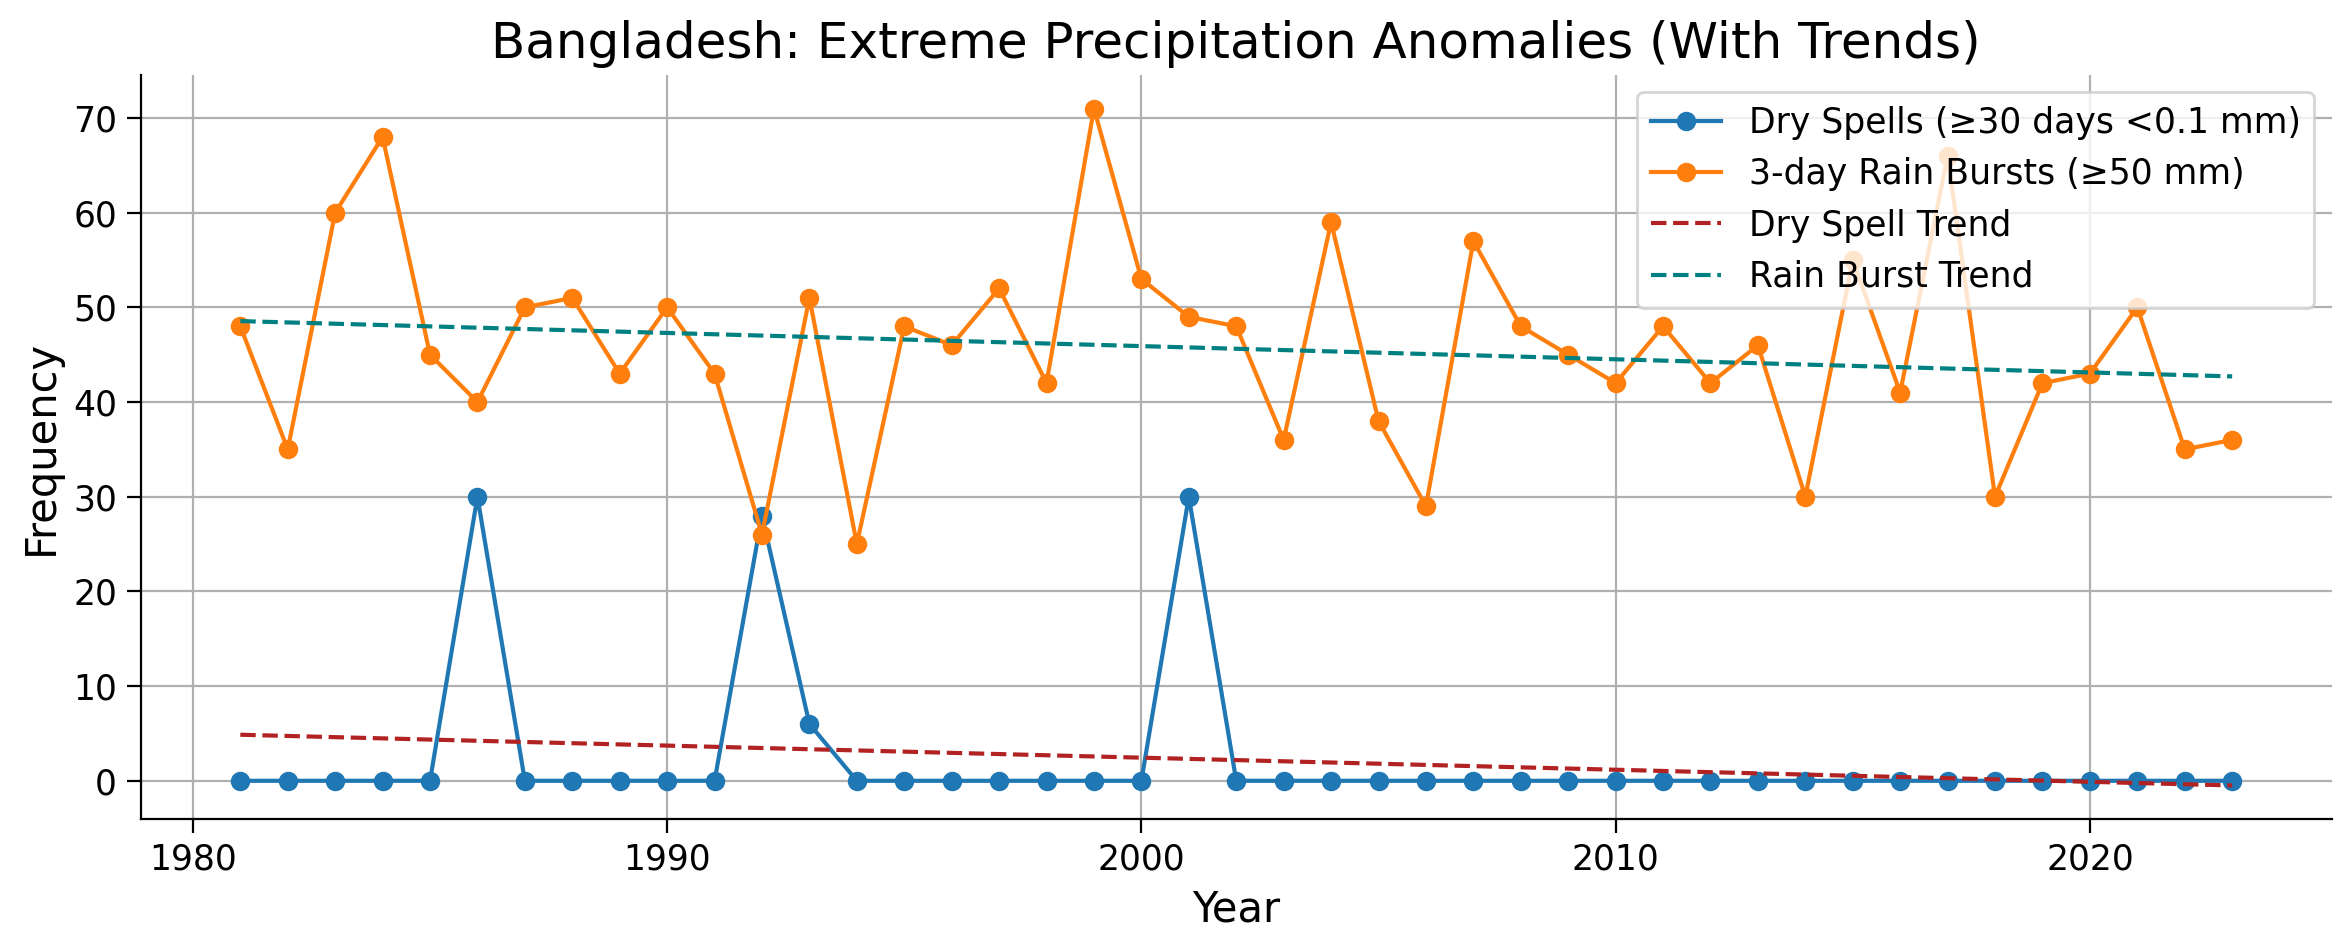

In [13]:
compute_extreme_anomalies_strict(bangladesh_precip, "Bangladesh")

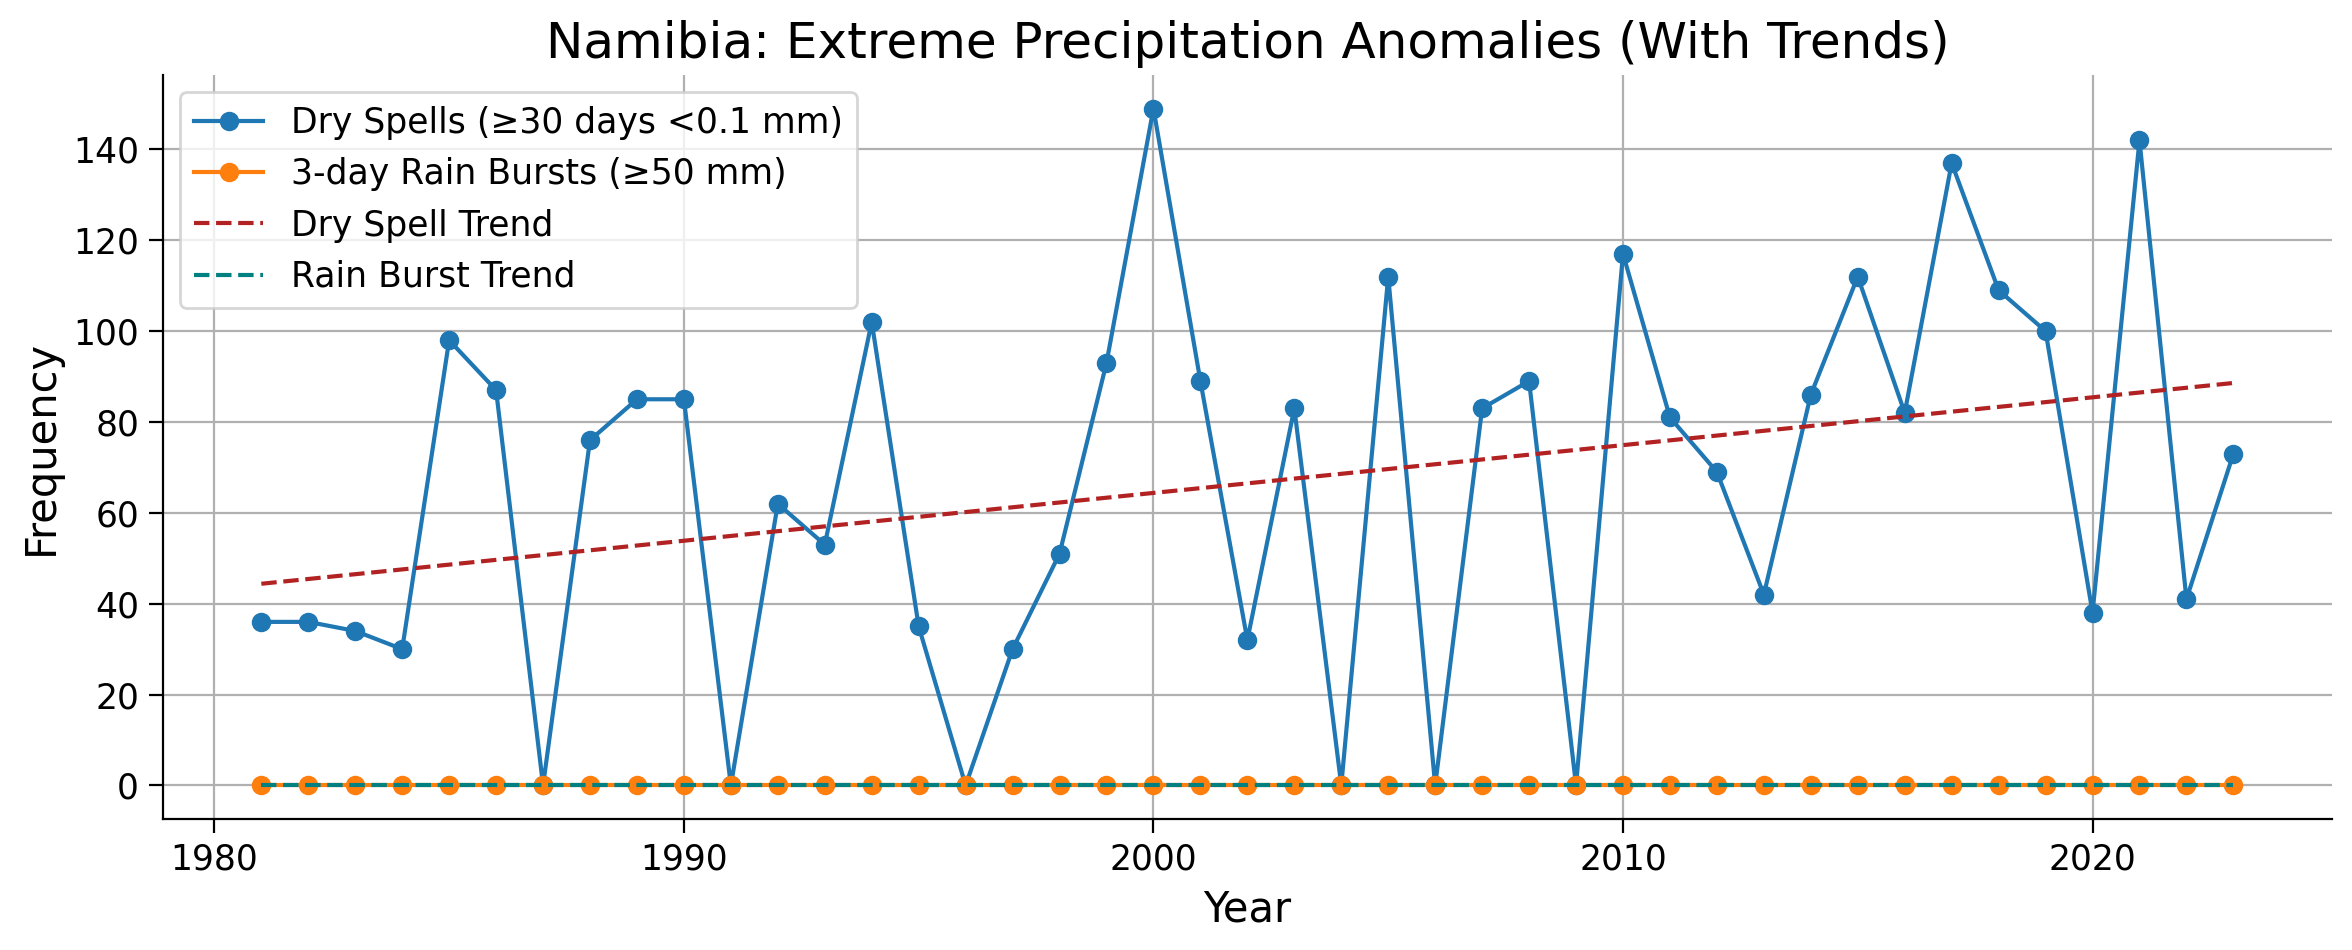

In [14]:
compute_extreme_anomalies_strict(namibia_precip, "Namibia")

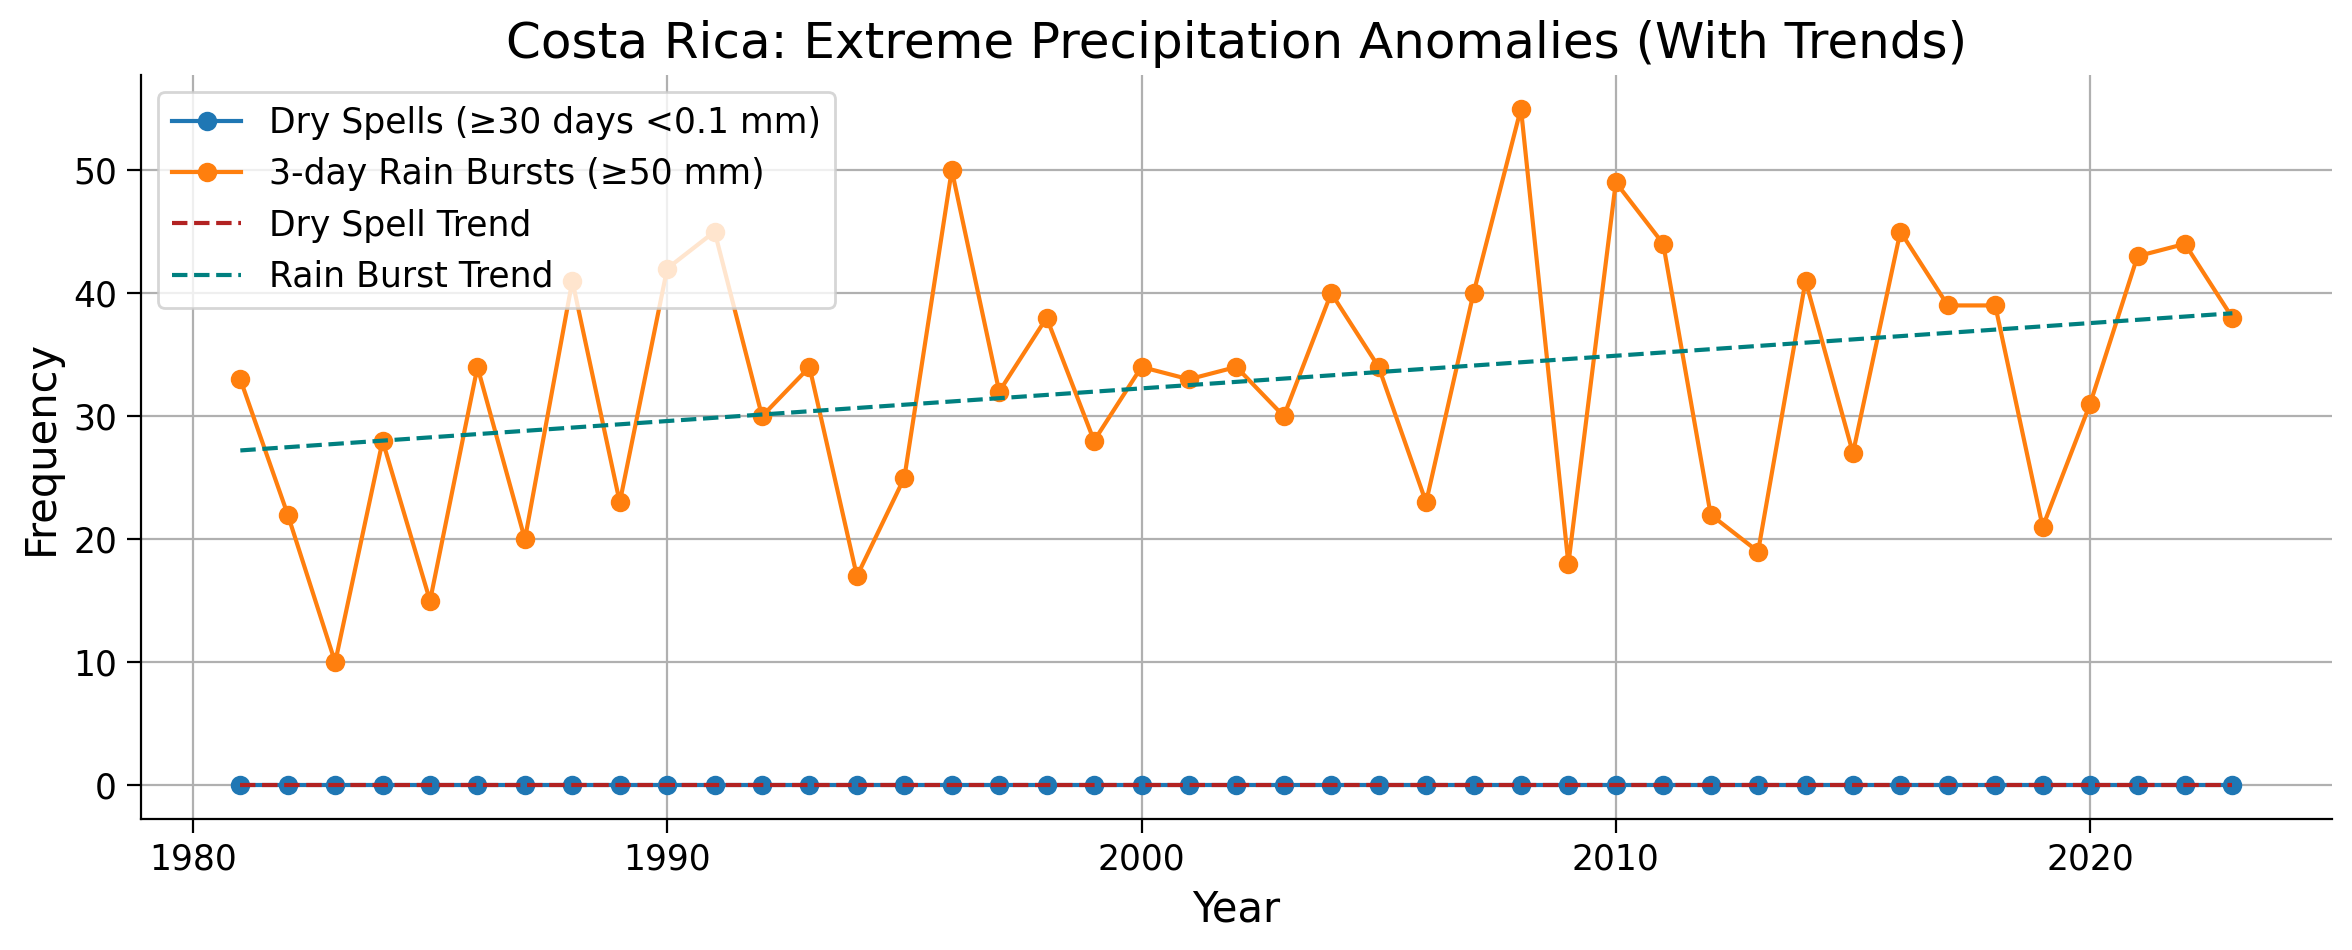

In [15]:
compute_extreme_anomalies_strict(costa_rica_precip, "Costa Rica")

#PART -2


## FAO Data: Cereal Production

Cereal production is a crucial component of global agriculture and food security. The [Food and Agriculture Organization](https://www.fao.org/faostat/en/#data/QCL) collects and provides data on cereal production, which includes crops such as wheat, rice, maize, barley, oats, rye, sorghum, millet, and mixed grains. The data covers various indicators such as production quantity, area harvested, yield, and production value.

The FAO also collects data on "area harvested", which refers to the area of land that is being used to grow cereal crops. This information can be valuable for assessing the productivity and efficiency of cereal production systems in different regions, as well as identifying potential areas for improvement. Overall, the FAO's data on cereal production and land under cereals production is an important resource for policymakers, researchers, and other stakeholders who are interested in understanding global trends in agriculture and food security.

In [ ]:
filename_cereal = 'data_cereal_land.csv'

url_cereal = 'https://raw.githubusercontent.com/Sshamekh/Heatwave/f85f43997e3d6ae61e5d729bf77cfcc188fbf2fd/data_cereal_land.csv'

path_cereal = 'shared/data/'
if os.path.exists(path_cereal + filename_cereal):
    ds_cereal_land = pd.read_csv(path_cereal + filename_cereal)
else:
    ds_cereal_land = pd.read_csv(pooch_load(url_cereal,filename_cereal))

ds_cereal_land.head()

SHA256 hash of downloaded file: 0d71645aeeb9e1cca8abe179c525c496f3b2b02867119069679762c0f9f1da47
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


,Country Name,Country Code,Series Name,Series Code,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],...,2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021]
0,Afghanistan,AFG,Cereal production (metric tons),AG.PRD.CREL.MT,3950000,4270000,4351000,4481000,4624000,4147000,...,6379000,6520329,6748023.28,5808288,5532695.42,4892953.97,4133051.85,5583461,6025977,4663880.79
1,Afghanistan,AFG,Land under cereal production (hectares),AG.LND.CREL.HA,3923100,3337000,3342000,3404000,3394000,3388000,...,3143000,3182922,3344733,2724070,2793694,2419213,1911652,2641911,3043589,2164537
2,Albania,ALB,Cereal production (metric tons),AG.PRD.CREL.MT,585830,625498,646200,666500,857000,910400,...,697400,702870,700370,695000,698430,701734,678196,666065,684023,691126.7
3,Albania,ALB,Land under cereal production (hectares),AG.LND.CREL.HA,331220,339400,334040,328500,350500,357000,...,142800,142000,143149,142600,148084,145799,140110,132203,131310,134337
4,Algeria,DZA,Cereal production (metric tons),AG.PRD.CREL.MT,2362625,1595994,1480275,2680452,2313186,1142509,...,5137455,4912551,3435535,3761229.6,3445227.37,3478175.14,6066252.82,5633596.78,4393336.75,2784017.29


In [ ]:
import pandas as pd
import os

# Load the dataset
filename_cereal = 'data_cereal_land.csv'
url_cereal = 'https://raw.githubusercontent.com/Sshamekh/Heatwave/f85f43997e3d6ae61e5d729bf77cfcc188fbf2fd/data_cereal_land.csv'

if os.path.exists(filename_cereal):
    ds_cereal_land = pd.read_csv(filename_cereal)
else:
    ds_cereal_land = pd.read_csv(url_cereal)

# Filter production and area data
prod = ds_cereal_land[ds_cereal_land["Series Code"] == "AG.PRD.CREL.MT"]
area = ds_cereal_land[ds_cereal_land["Series Code"] == "AG.LND.CREL.HA"]

# Clean year column headers (e.g., "2012 [YR2012]" → 2012)
def clean_year_columns(df):
    new_cols = []
    for col in df.columns:
        if "[" in col and "YR" in col:
            try:
                year = int(col.split()[0])
                new_cols.append(year)
            except:
                new_cols.append(col)
        else:
            new_cols.append(col)
    df.columns = new_cols
    return df

prod = clean_year_columns(prod)
area = clean_year_columns(area)

# Ensure numeric data
for df in [prod, area]:
    for col in df.columns[4:]:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Compute yield = production / area
yield_df = prod.copy()
yield_df.iloc[:, 4:] = prod.iloc[:, 4:].values / area.iloc[:, 4:].values
yield_df["Series Name"] = "Cereal yield (metric tons per hectare)"
yield_df["Series Code"] = "AG.YLD.CREL.TPHA"

# Extract data for specific countries
countries = ["Costa Rica", "Namibia", "Bangladesh"]
yield_selected = yield_df[yield_df["Country Name"].isin(countries)]

# Keep only year columns and country names
yield_selected = yield_selected.set_index("Country Name")
year_cols = [col for col in yield_selected.columns if isinstance(col, int) and col >= 1980]
yield_selected = yield_selected[year_cols]

# Transpose and rename
yield_selected = yield_selected.transpose()
yield_selected.index.name = "Year"
yield_selected.columns.name = None

# Save to Excel
yield_selected.to_excel("cereal_yield_1980_2021.xlsx")

print("✅ Excel file 'cereal_yield_1980_2021.xlsx' saved successfully.")



/tmp/ipython-input-15-992398539.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')
/tmp/ipython-input-15-992398539.py:42: RuntimeWarning: divide by zero encountered in divide
  yield_df.iloc[:, 4:] = prod.iloc[:, 4:].values / area.iloc[:, 4:].values
/tmp/ipython-input-15-992398539.py:42: RuntimeWarning: invalid value encountered in divide
  yield_df.iloc[:, 4:] = prod.iloc[:, 4:].values / area.iloc[:, 4:].values


✅ Excel file 'cereal_yield_1980_2021.xlsx' saved successfully.


In [ ]:
def get_yield_series(country):
    return yield_df[yield_df["Country Name"] == country]\
        .drop(["Country Name", "Country Code", "Series Name", "Series Code"], axis=1)\
        .reset_index(drop=True).transpose()

yield_costa_rica = get_yield_series("Costa Rica")
yield_namibia = get_yield_series("Namibia")
yield_bangladesh = get_yield_series("Bangladesh")

# Optional: Rename columns for readability
yield_costa_rica.columns = ["Costa Rica"]
yield_namibia.columns = ["Namibia"]
yield_bangladesh.columns = ["Bangladesh"]

yield_costa_rica.head()


,Costa Rica
1972,1.870833
1973,1.388807
1974,1.574992
1975,1.895633
1976,1.713137


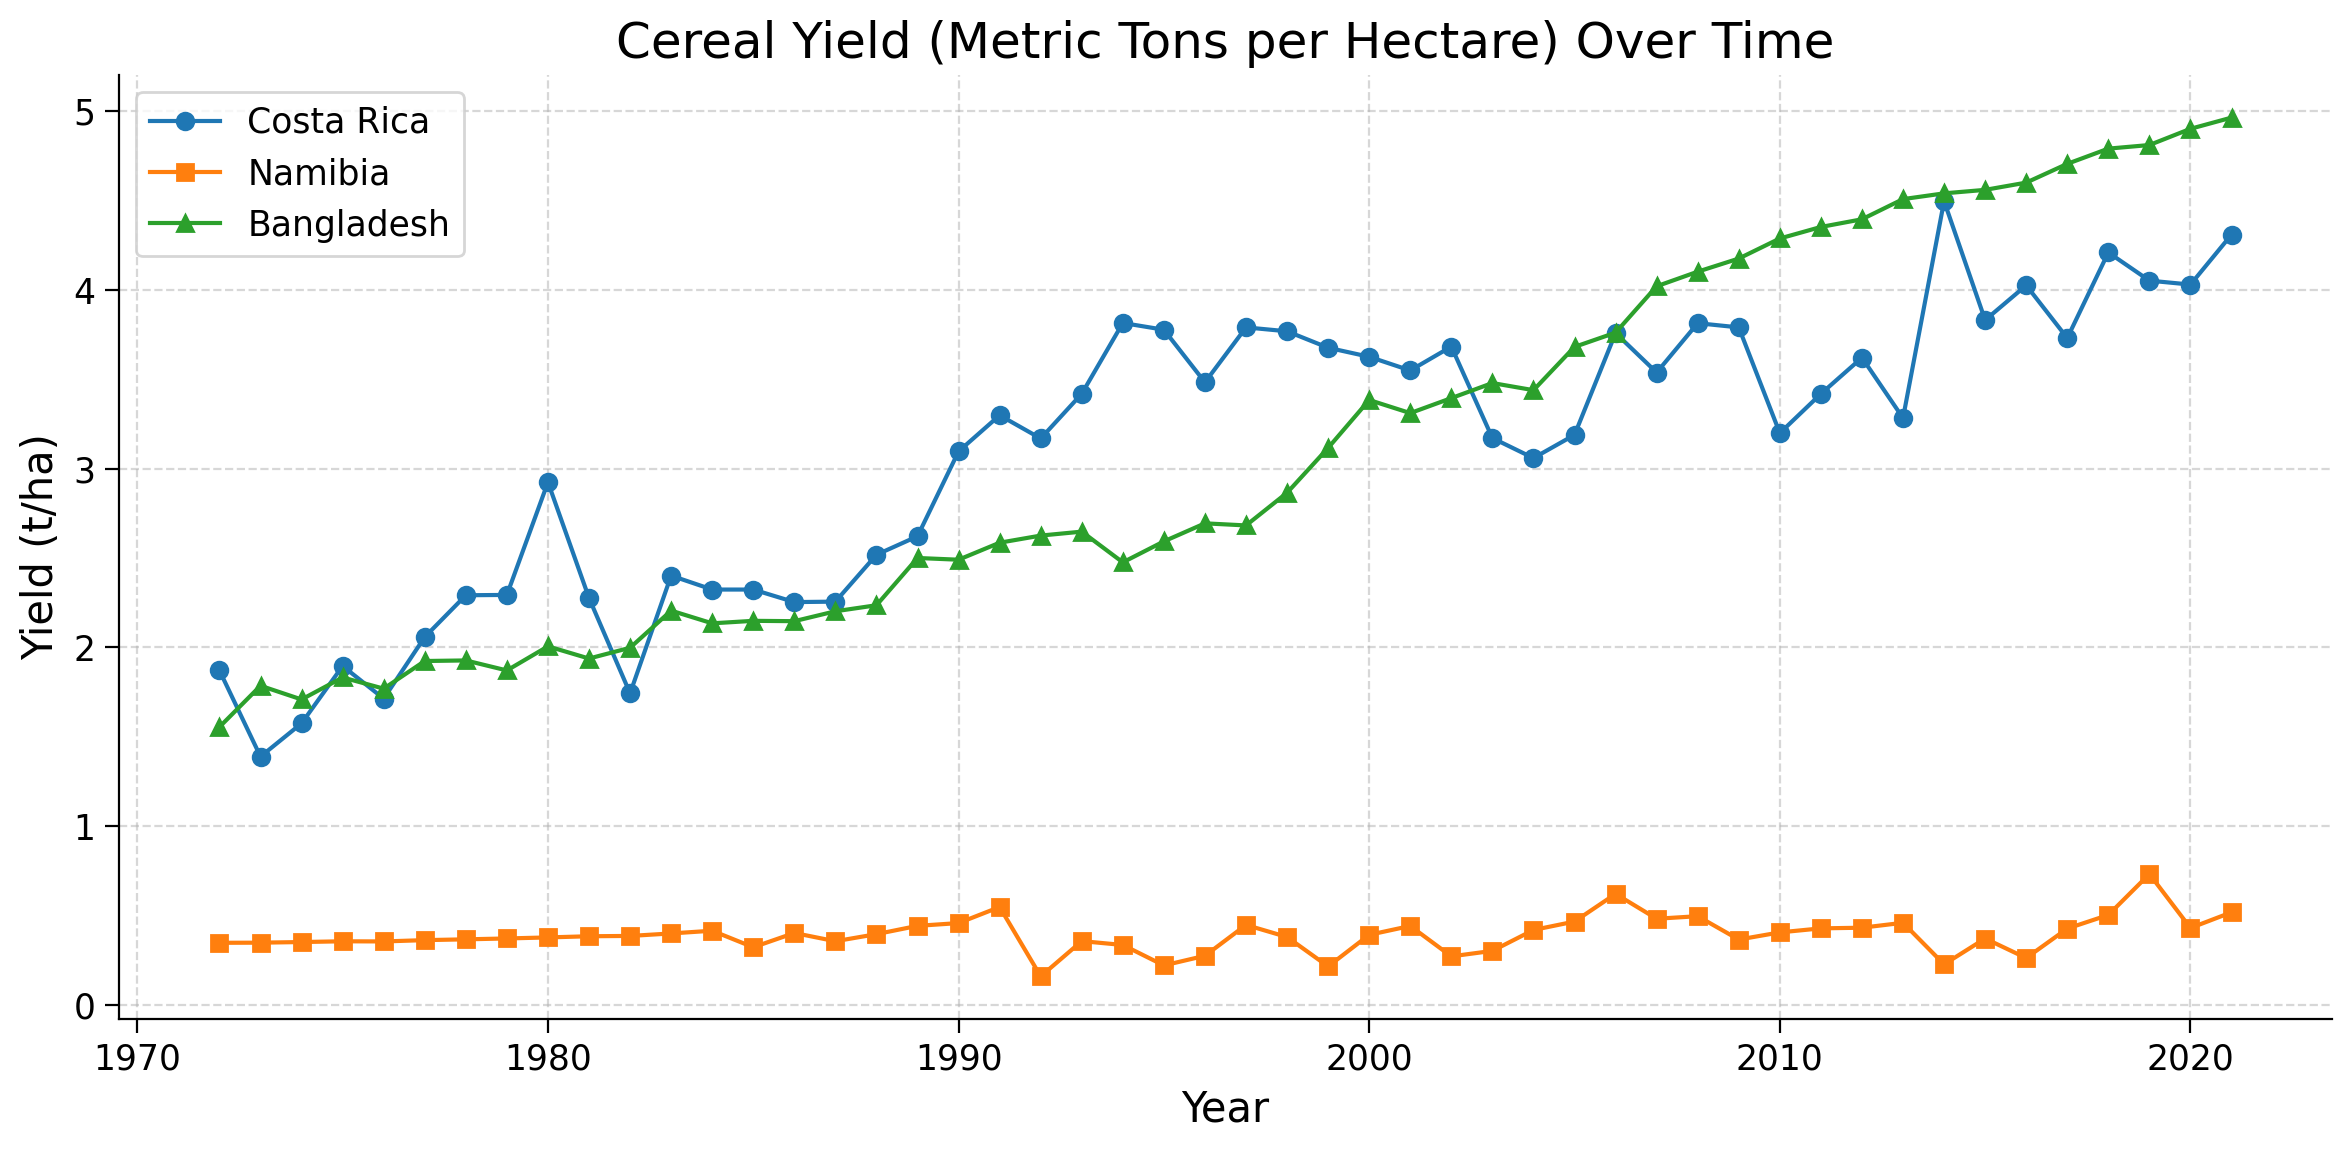

In [ ]:
import matplotlib.pyplot as plt

# Merge the 3 country series into a single DataFrame
combined_yield = pd.concat([yield_costa_rica, yield_namibia, yield_bangladesh], axis=1)

# Make sure index is integer years (optional safety check)
combined_yield.index = combined_yield.index.astype(int)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(combined_yield.index, combined_yield["Costa Rica"], label="Costa Rica", marker='o')
plt.plot(combined_yield.index, combined_yield["Namibia"], label="Namibia", marker='s')
plt.plot(combined_yield.index, combined_yield["Bangladesh"], label="Bangladesh", marker='^')

plt.title("Cereal Yield (Metric Tons per Hectare) Over Time")
plt.xlabel("Year")
plt.ylabel("Yield (t/ha)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


We can now visualize the content of the dataset.

In [ ]:
import pandas as pd
import numpy as np

def get_extreme_anomaly_frequencies(region_precip):
    df = region_precip.compute().to_series()

    # Dry Spell: ≥30 days < 0.1 mm
    dry_days = df < 0.1
    dry_spell_groups = (dry_days != dry_days.shift()).cumsum()
    dry_spell_lengths = dry_days.groupby(dry_spell_groups).transform('sum')
    extreme_dry_spells = dry_days & (dry_spell_lengths >= 30)
    drought_freq = extreme_dry_spells.groupby(df.index.year).sum()

    # Rain Burst: 3-day total ≥ 50 mm
    rolling_3day = df.rolling(window=3).sum()
    extreme_rain_bursts = rolling_3day >= 50
    flood_freq = extreme_rain_bursts.groupby(df.index.year).sum()

    return drought_freq, flood_freq

# Replace these with your actual DataArrays or Series with datetime index
# Each should be daily precipitation time series per country
regions = {
    "Costa Rica": costa_rica_precip,
    "Namibia": namibia_precip,
    "Bangladesh": bangladesh_precip
}

# Store results
dry_df = pd.DataFrame()
wet_df = pd.DataFrame()

# Process each country
for country, data in regions.items():
    drought_freq, flood_freq = get_extreme_anomaly_frequencies(data)
    dry_df[country] = drought_freq
    wet_df[country] = flood_freq

# Filter years from 1980 onwards
dry_df = dry_df[dry_df.index >= 1980]
wet_df = wet_df[wet_df.index >= 1980]

# Rename index to "Year"
dry_df.index.name = "Year"
wet_df.index.name = "Year"

# Export to Excel
with pd.ExcelWriter("extreme_precip_anomalies.xlsx") as writer:
    dry_df.to_excel(writer, sheet_name="Dry Spells")
    wet_df.to_excel(writer, sheet_name="Rain Bursts")

print("✅ Saved extreme precipitation anomalies to 'extreme_precip_anomalies.xlsx'")



✅ Saved extreme precipitation anomalies to 'extreme_precip_anomalies.xlsx'


In [ ]:
# Check for NaN values in cereal yield data
nan_yield = combined_yield.isna().sum()
print("NaN values in cereal yield data:")
print(nan_yield)

# Optional: show exact years with NaNs (if any)
print("\nYears with missing data:")
print(combined_yield[combined_yield.isna().any(axis=1)])


NaN values in cereal yield data:
Costa Rica    0
Namibia       0
Bangladesh    0
dtype: int64

Years with missing data:
Empty DataFrame
Columns: [Costa Rica, Namibia, Bangladesh]
Index: []


## NOAA Fundamental Climate Data Records (FCDR) AVHRR Land Bundle - Normalized Difference Vegetation Index

As we learned in the W1D3 tutorials, all the National Atmospheric and Oceanic Administration Climate Data Record (NOAA-CDR) datasets are available both at NOAA National Centers for Environmental Information (NCEI) and commercial cloud platforms. See the link [here](https://registry.opendata.aws/noaa-cdr-terrestrial/). We are accessing the data directly via the [Amazon Web Service (AWS) cloud storage space](https://noaa-cdr-ndvi-pds.s3.amazonaws.com/index.html).

For this project, we recommend using the Normalized Difference Vegetation Index (NDVI). It is one of the most commonly used remotely sensed indices. It measures the "greenness" of vegetation and is useful in understanding vegetation density and assessing changes in plant health. For example, NDVI can be used to study the impacts of droughts, heatwaves, and insect infestations on plants covering Earth's surface. A good overview of this index from this particular sensor can be accessed [here](https://digitalcommons.unl.edu/nasapub/217/).

Recall what we learned in W1D3 Tutorial 3, the data files on AWS are named systematically:

> Sensor name: `AVHRR`  
> Product category: `Land`  
> Product version: `v005`  
> Product code: `AVH13C1`  
> Satellite platform: `NOAA-07`  
> Date of the data: `19810624`  
> Processing time: `c20170610041337` (*This will change for each file based on when the file was processed*)  
> File format: `.nc` (*netCDF-4 format*)

In other words, if we are looking for the data of a specific day, we can easily locate where the file might be.

For example, if we want to find the AVHRR data for the day of *2002-03-12 (or March 12, 2002)*, you can use:

`s3://noaa-cdr-ndvi-pds/data/2002/AVHRR-Land_v005_AVH13C1_*_20020312_c*.nc`

The reason that we put `*` in the above directory is that we are not sure about what satellite platform this data is from and when the data was processed. The `*` is called a **wildcard**, and is used because we want *all* the files that contain our specific criteria, but do not want to have to specify all the other pieces of the filename we are not sure about yet. It should return all the data satisfying that initial criteria and you can refine further once you see what is available. Essentially, this first step helps to narrow down the data search. You can then use this to create datasets from the timeframe of your choosing.

*Note the download might take up to hours depending on your time frame of interest and your device. Choose your time frame wisely before taking action to avoid unnecessary data retrieval amounts.*

In [ ]:
import s3fs
import xarray as xr
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import datetime
import os

# 1. Initialize connection
fs = s3fs.S3FileSystem(anon=True, client_kwargs={'region_name':'us-east-1'})
BASE_PATH = "s3://noaa-cdr-ndvi-pds/data"

# 2. Define regions
REGIONS = {
    "Bangladesh": {"lat": (20.5, 26.6), "lon": (88.0, 92.7)},
    "CostaRica": {"lat": (8.0, 11.5), "lon": (-85.9, -82.5)},
    "Namibia": {"lat": (-28.6, -17.5), "lon": (11.5, 25.3)}
}

# 3. Quality control function
def get_quality_info(ds):
    """Handles different quality flag versions"""
    try:
        if 'NDVI_QC' in ds:
            QA = ds['NDVI_QC']
            cld_flag = (QA % (2**2)) // 2
            cld_shadow = (QA % (2**3)) // 2**2
            value_valid = (QA % (2**8)) // 2**7
            return (cld_flag == 0) & (cld_shadow == 0) & (value_valid == 1)
        elif 'quality_flag' in ds:
            return ds['quality_flag'] == 0
        else:
            return xr.ones_like(ds['NDVI'], dtype=bool)
    except:
        return xr.ones_like(ds['NDVI'], dtype=bool)

# 4. Corrected file processing
def process_file(s3_path, region):
    try:
        with fs.open(s3_path) as f:
            ds = xr.open_dataset(f)

            # Handle dimension names
            lat_dim = 'latitude' if 'latitude' in ds.dims else 'lat'
            lon_dim = 'longitude' if 'longitude' in ds.dims else 'lon'

            qa_mask = get_quality_info(ds)
            ndvi = ds['NDVI'].where(qa_mask)

            # CORRECTED: Properly closed parentheses
            region_ndvi = ndvi.sel(
                **{lat_dim: slice(region["lat"][1], region["lat"][0])},
                **{lon_dim: slice(region["lon"][0], region["lon"][1])}
            ).mean()

            return {
                "year": year,
                "month": month,
                "region": region_name,
                "ndvi": float(region_ndvi.values),
                "source_file": os.path.basename(s3_path)
            }
    except Exception as e:
        print(f"Error processing {os.path.basename(s3_path)}: {str(e)}")
        return None

# 5. Main processing (test with 2 years first)
results = []
years = range(2021, 2022)

for year in tqdm(years, desc="Processing years"):
    for month in range(1, 13):
        for day in [15, 14, 16]:  # Try 15th ±1 day first
            try:
                date = datetime.datetime(year, month, day)
                #s3_path = f"{BASE_PATH}/{year}/AVHRR-Land_v005_AVH13C1_*{date.strftime('%Y%m%d')}_c*.nc"
                #AVHRR-Land_v005_AVH13C1_NOAA-19_20100101_c20170406091314.nc
                #VIIRS-Land_v001_NPP13C1_S-NPP_20150101_c20240124140047.nc
                s3_path = f"{BASE_PATH}/{year}/VIIRS-Land_v001_NPP13C1_*{date.strftime('%Y%m%d')}_c*.nc"
                files = fs.glob(s3_path)
                if files:
                    for region_name, coords in REGIONS.items():
                        result = process_file(files[0], coords)
                        if result:
                            results.append(result)
                    break  # Stop after first successful day
            except Exception as e:
                print(f"Error finding file for {year}-{month}-{day}: {str(e)}")

# 6. Save results
if results:
    ndvi_df = pd.DataFrame(results)
    annual_ndvi = ndvi_df.groupby(['year', 'region'])['ndvi'].mean().unstack()
    annual_ndvi.columns = [f"NDVI_{col}" for col in annual_ndvi.columns]
    annual_ndvi = annual_ndvi.reset_index().rename(columns={'year':'Year'})

    with pd.ExcelWriter("ndvi_results.xlsx") as writer:
        ndvi_df.to_excel(writer, sheet_name="Monthly", index=False)
        annual_ndvi.to_excel(writer, sheet_name="Annual", index=False)

    print("✅ Success! Data saved to ndvi_results.xlsx")
    print(f"Processed {len(results)} records across {len(years)} years")
else:
    print("❌ No data processed - check error messages above")

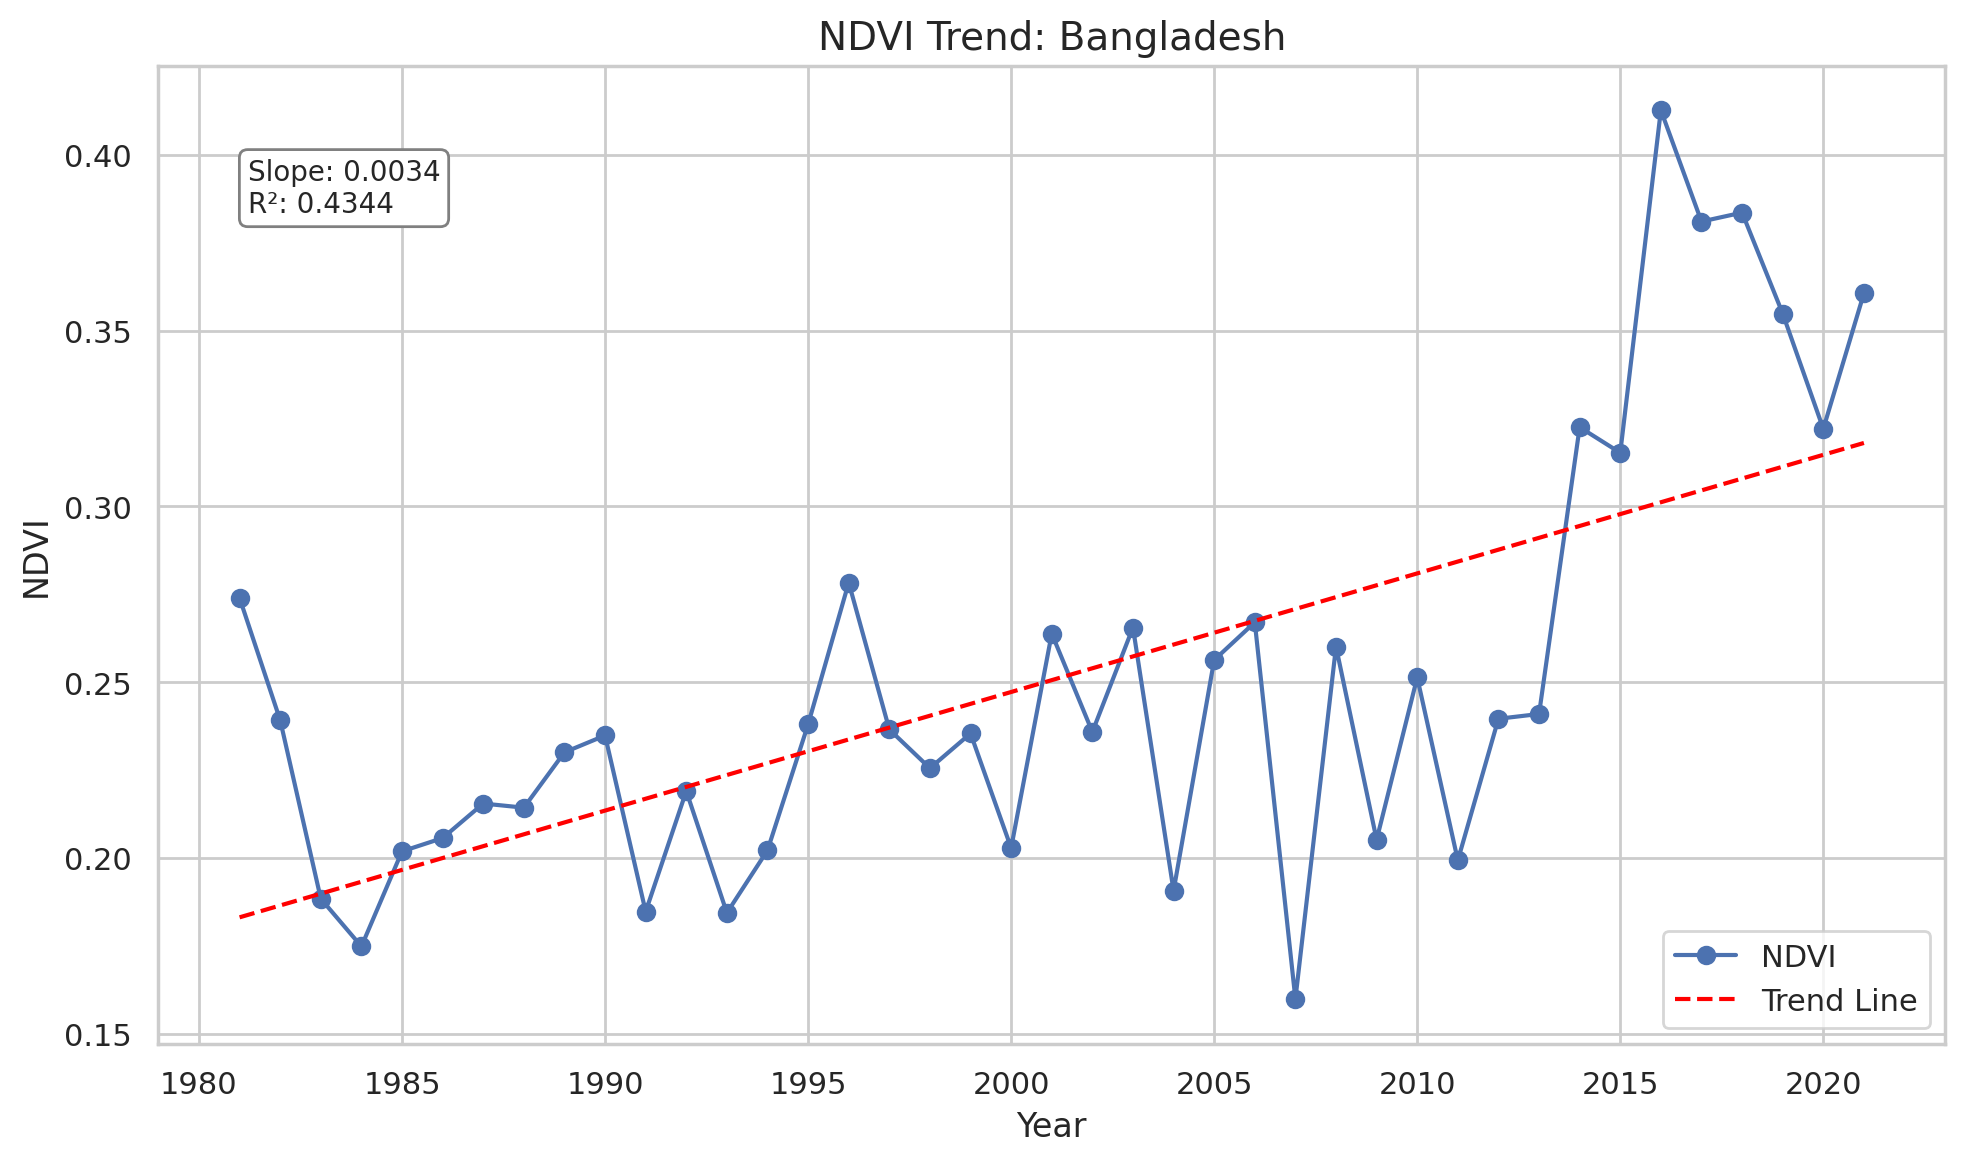

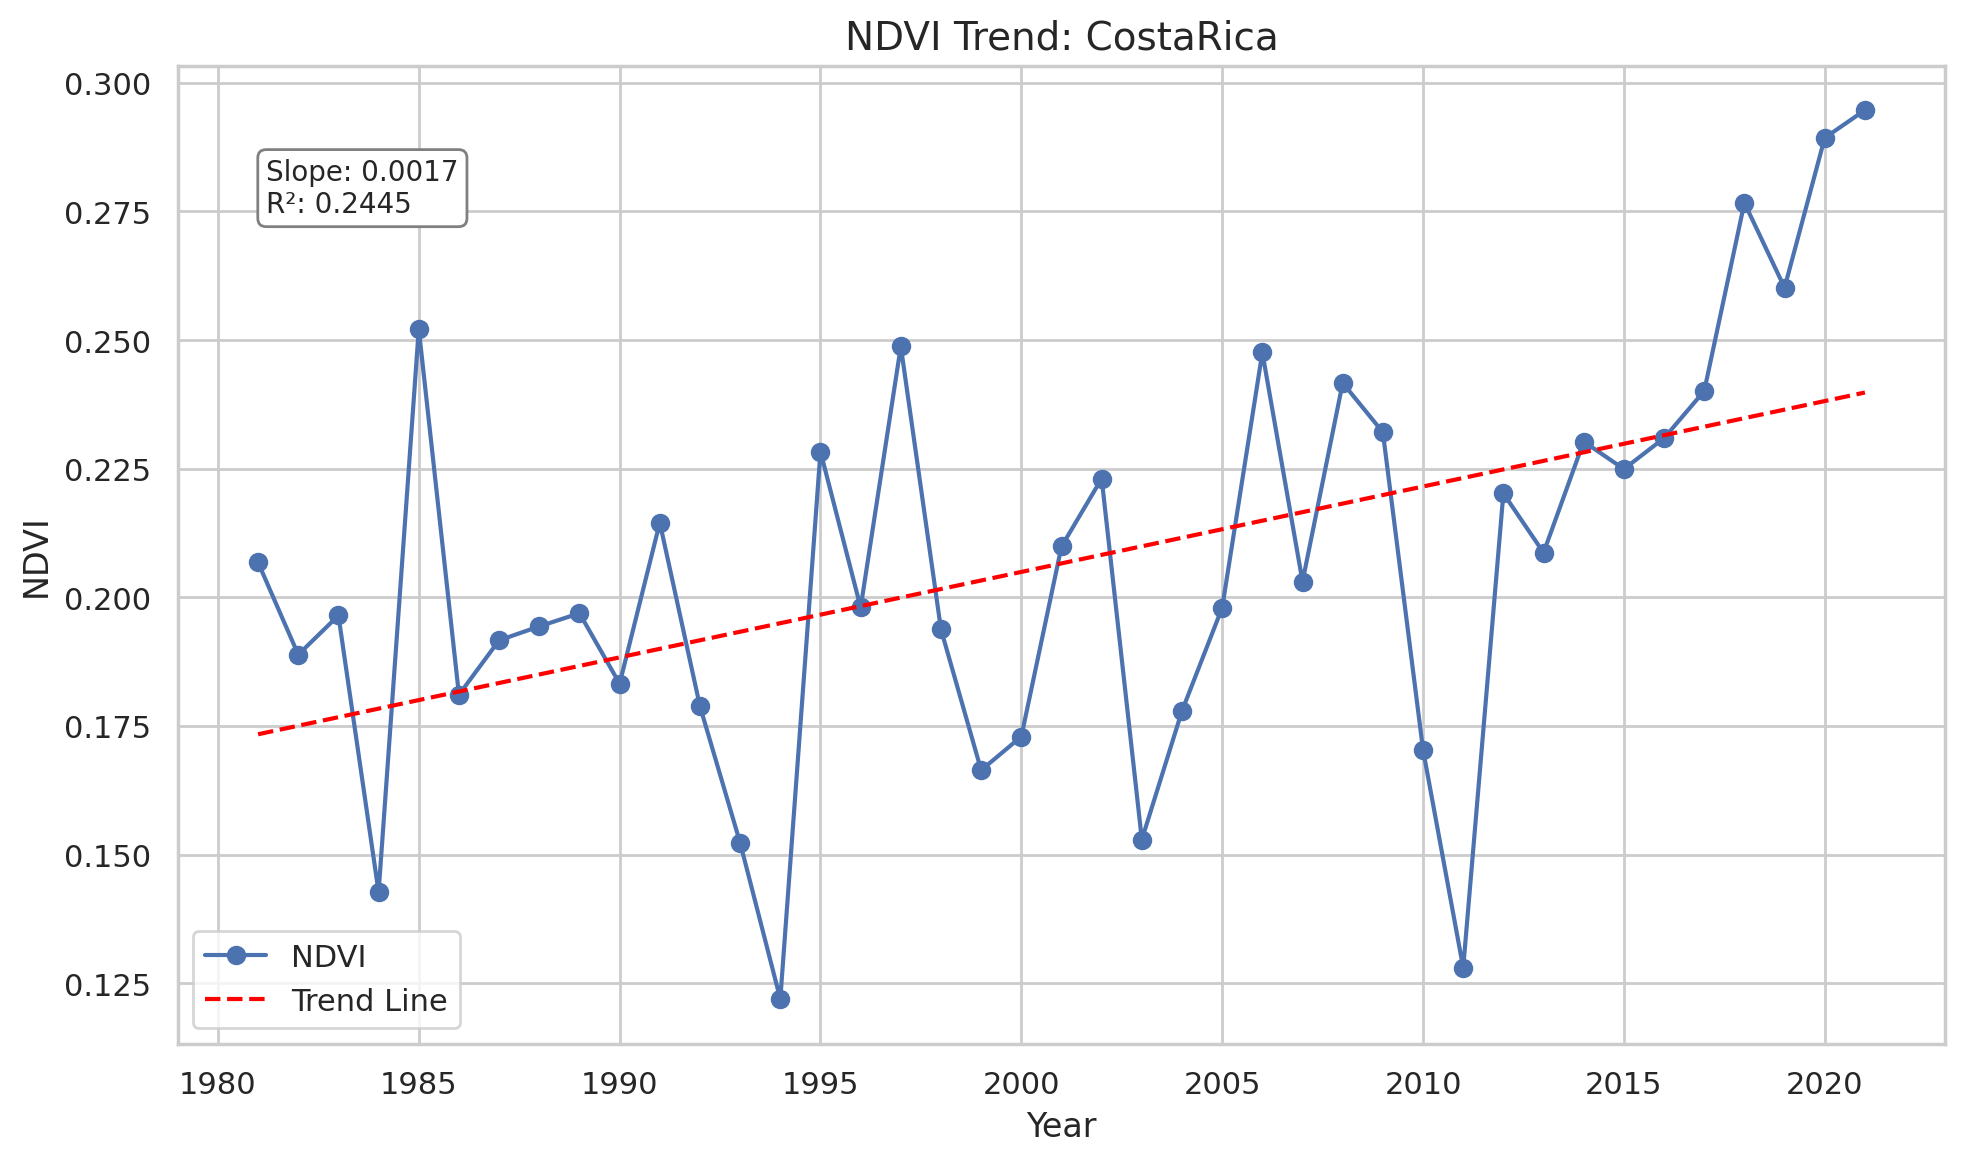

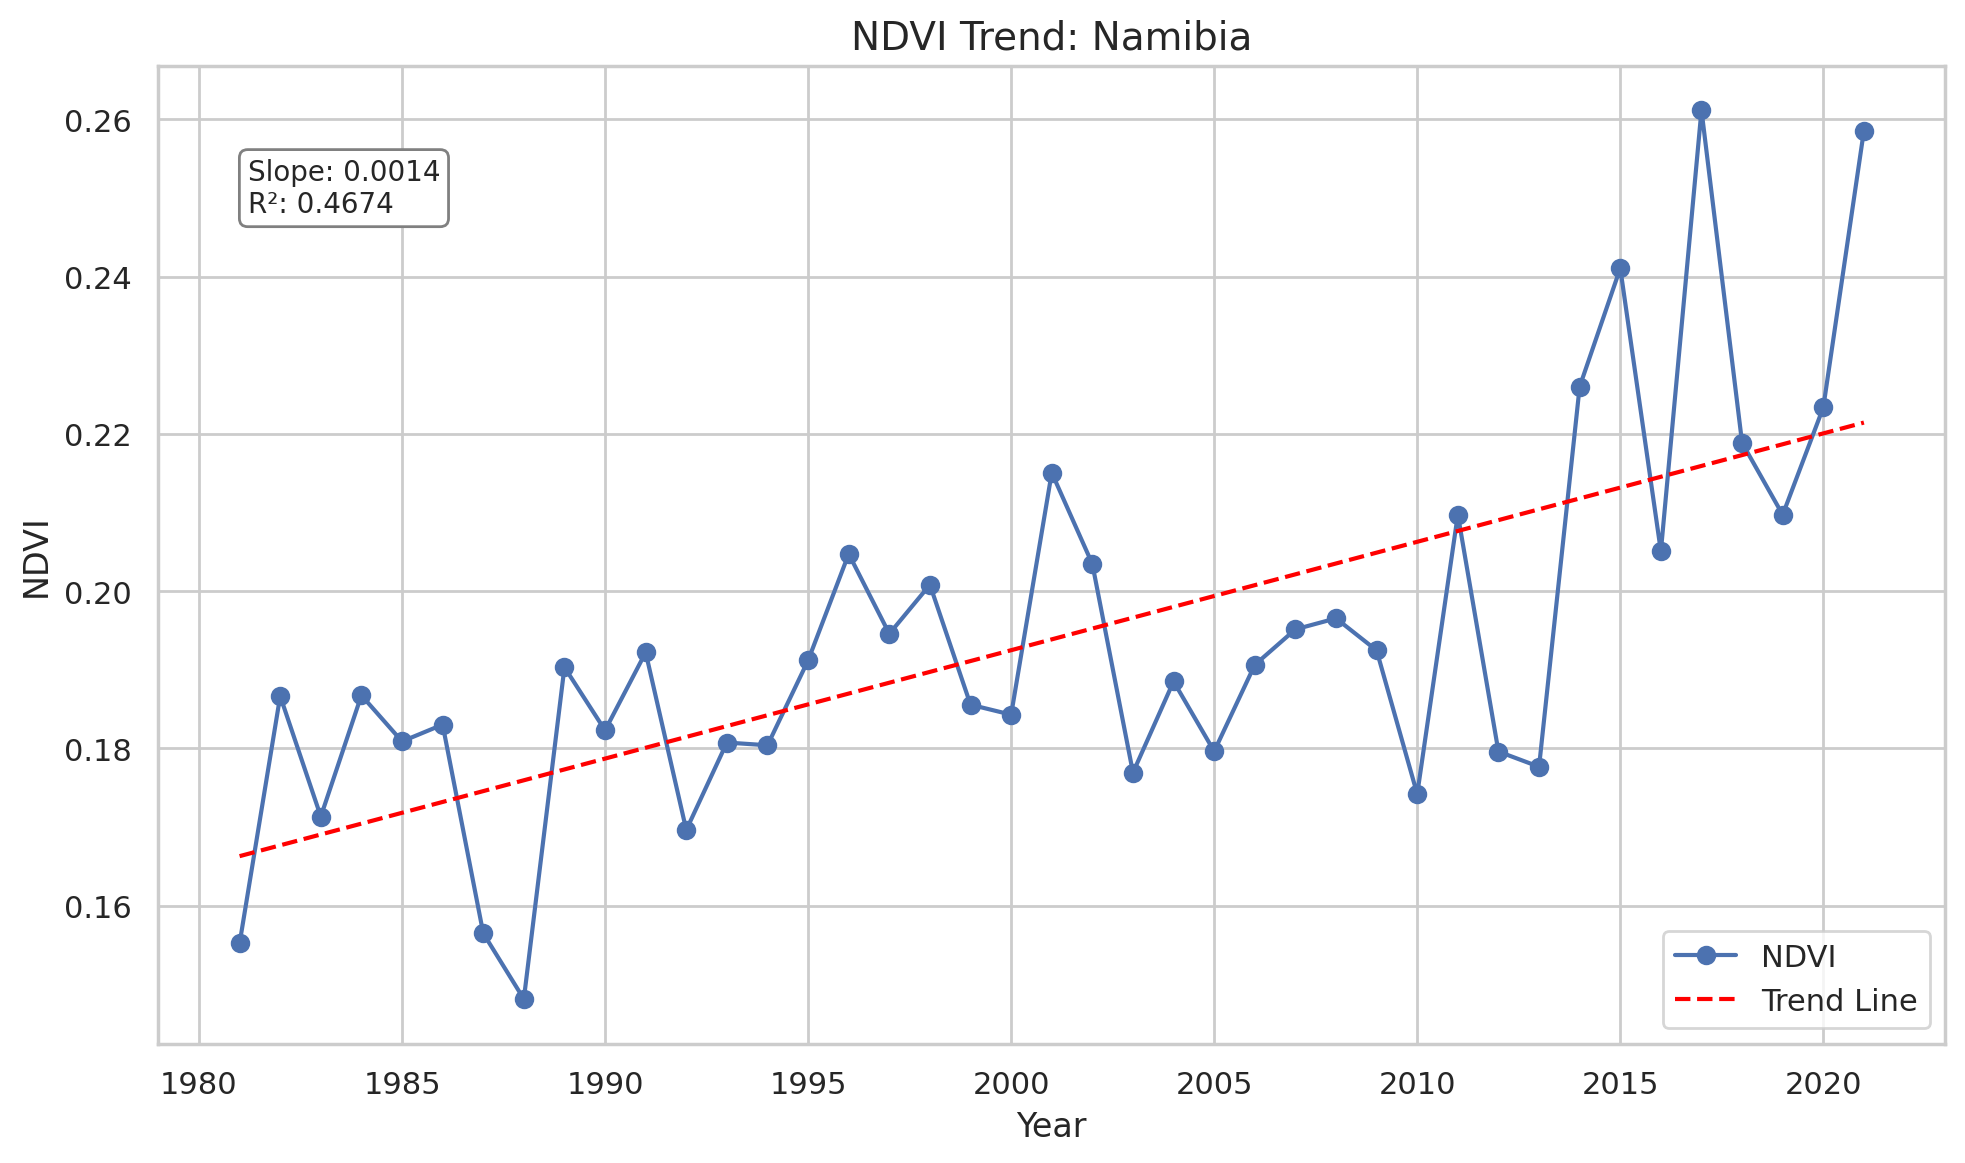

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

# Load the data (replace this with your actual DataFrame if already loaded)
df = pd.read_excel("Precip_2.xlsx", sheet_name="Vegitation")

# Set plot style
sns.set(style="whitegrid")
regions = ["Bangladesh", "CostaRica", "Namibia"]

# Create one plot per region
for region in regions:
    col_name = f"{region}"

    # Drop rows with NaNs (if any)
    sub_df = df[['Year', col_name]].dropna()

    # Regression
    X = sub_df['Year'].values.reshape(-1, 1)
    y = sub_df[col_name].values
    model = LinearRegression()
    model.fit(X, y)
    trend = model.predict(X)
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(X, y)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(sub_df['Year'], y, marker='o', label='NDVI')
    plt.plot(sub_df['Year'], trend, linestyle='--', color='red', label='Trend Line')
    plt.title(f"NDVI Trend: {region}", fontsize=14)
    plt.xlabel("Year")
    plt.ylabel("NDVI")
    plt.legend()
    plt.annotate(f"Slope: {slope:.4f}\nR²: {r2:.4f}",
                 xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10,
                 bbox=dict(boxstyle="round", fc="w", ec="gray"))
    plt.tight_layout()
    plt.show()

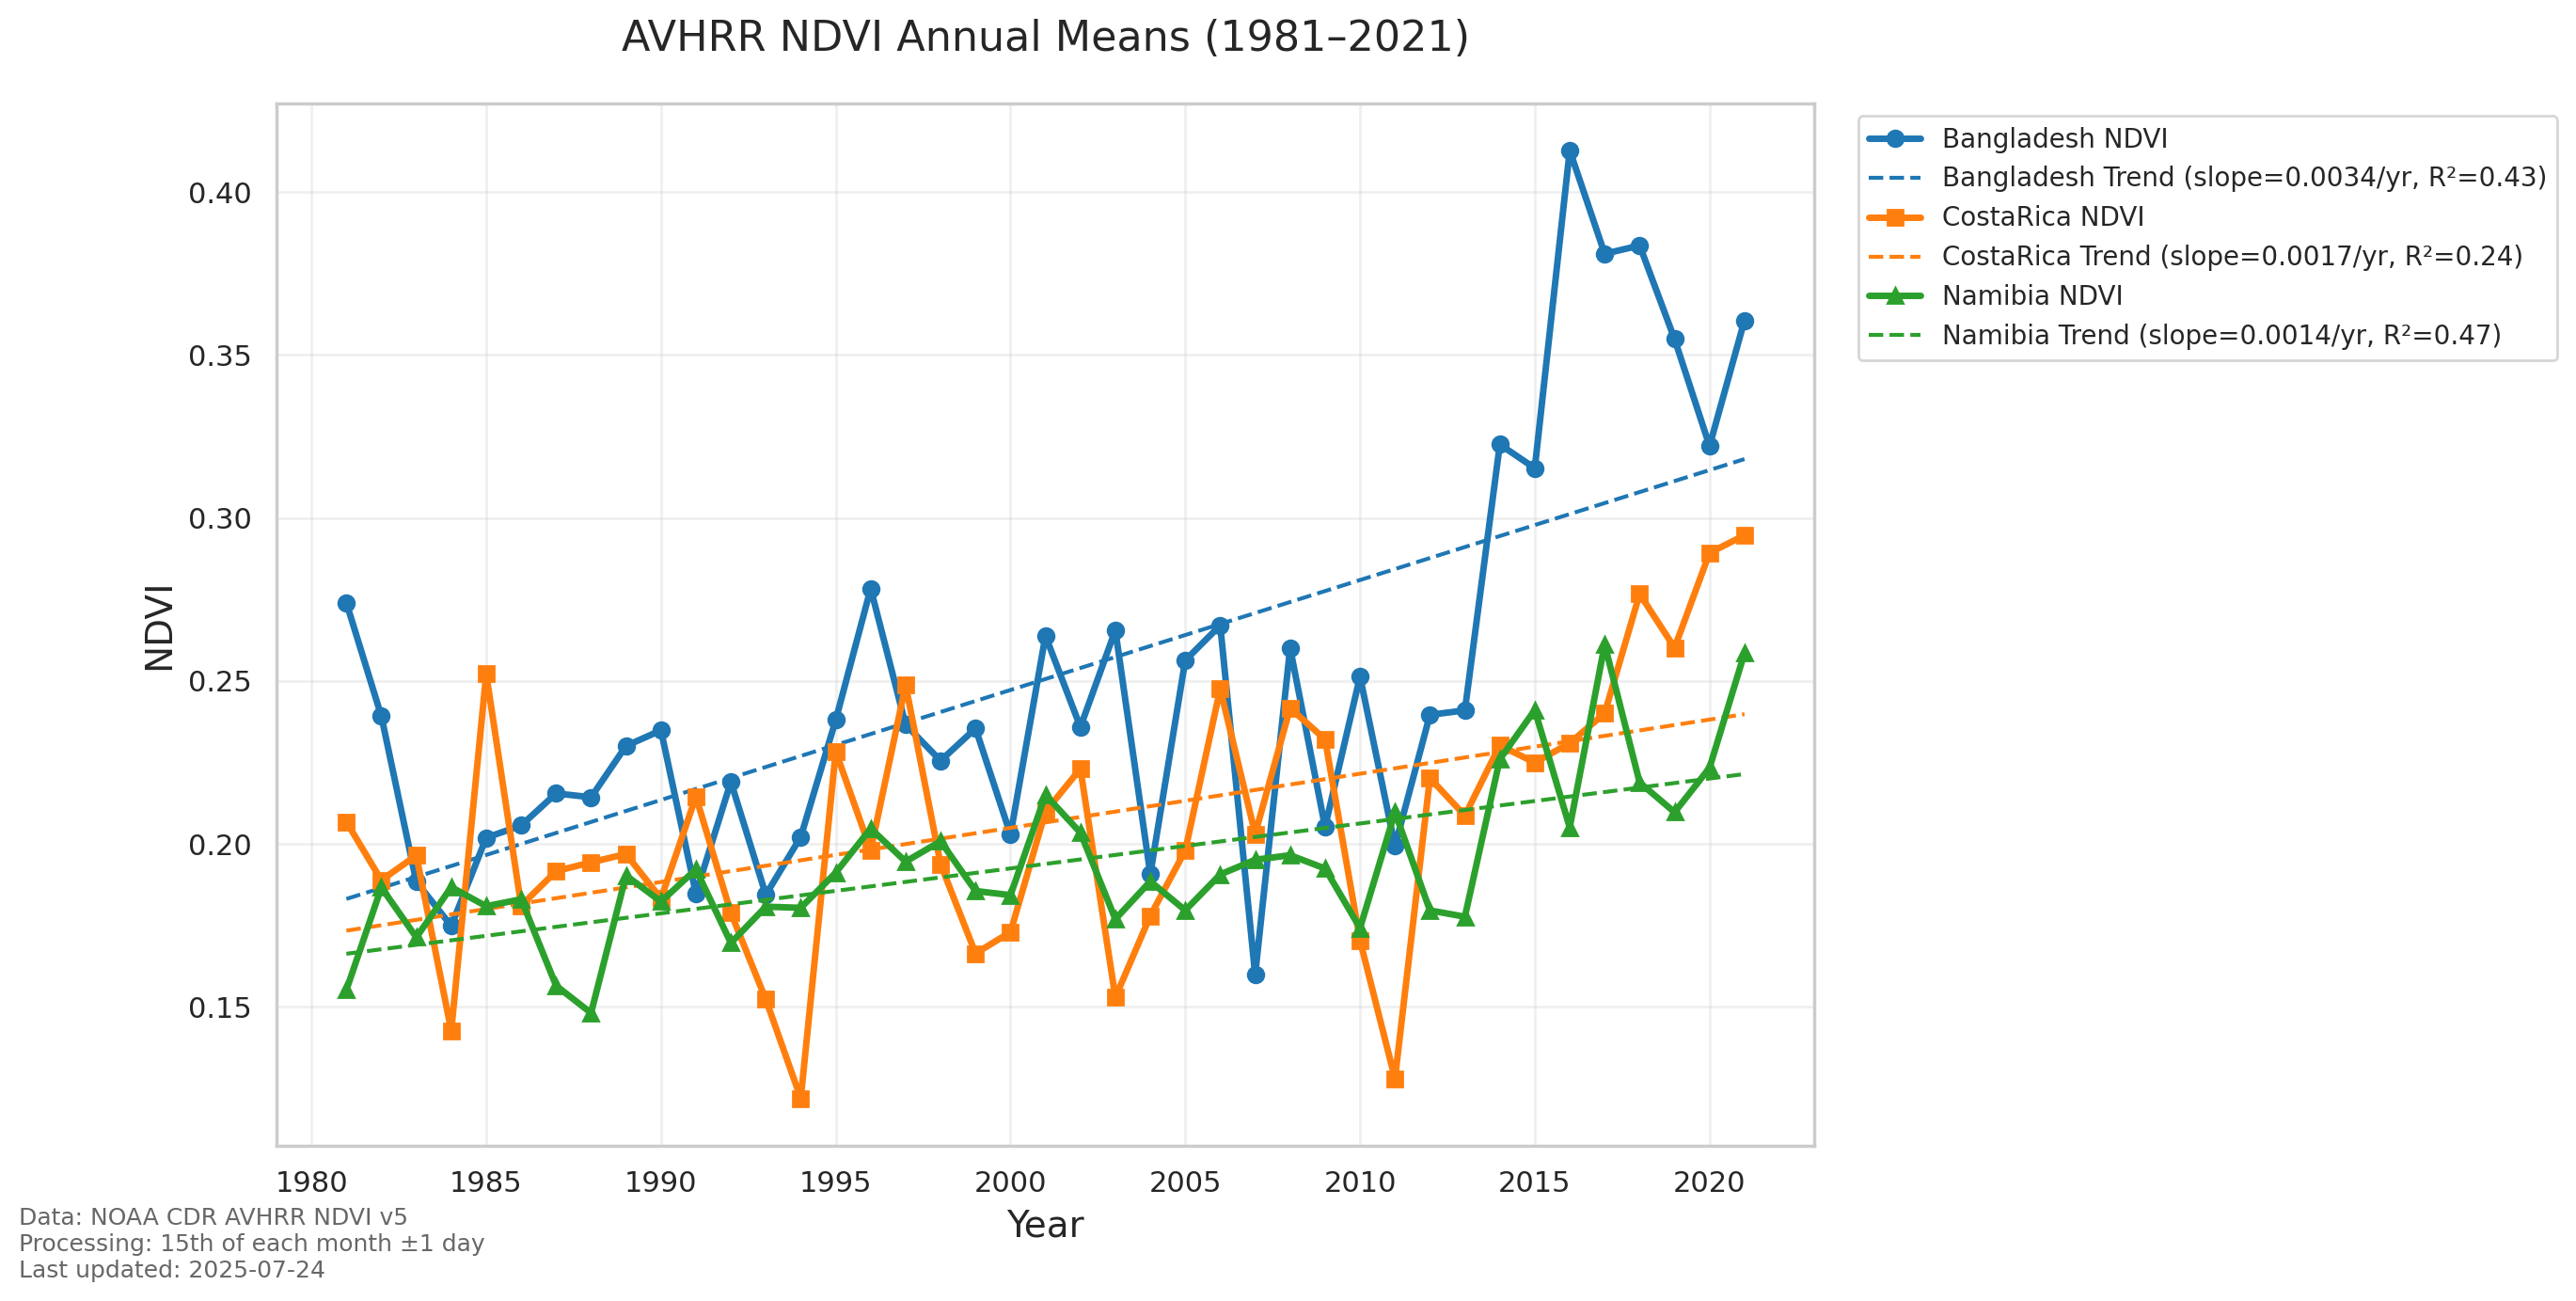

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd

# Load wide-format data
df1 = pd.read_excel("Precip_2.xlsx", sheet_name="Vegitation")

# Convert to long format: columns = Year | region | ndvi
ndvi_df = df1.melt(id_vars='Year', var_name='region', value_name='ndvi')
ndvi_df.rename(columns={"Year": "year"}, inplace=True)

# Seaborn style with gridlines
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

# Prepare annual data
annual_data = ndvi_df.groupby(['year', 'region'])['ndvi'].mean().unstack()

# Color palette for the regions
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
markers = ['o', 's', '^']  # Optional: unique marker for each region

# Loop through each region
for i, region in enumerate(annual_data.columns):
    years = annual_data.index.values.reshape(-1, 1)
    ndvi_vals = annual_data[region].values

    # Drop NaNs for regression
    valid = ~np.isnan(ndvi_vals)
    X = years[valid]
    y = ndvi_vals[valid]

    # Fit linear regression
    model = LinearRegression()
    model.fit(X, y)
    trend = model.predict(X)
    slope = model.coef_[0]
    r2 = model.score(X, y)

    # Plot actual NDVI values with markers
    plt.plot(X.flatten(), y,
             marker=markers[i],
             linestyle='-',
             color=colors[i],
             label=f"{region} NDVI",
             linewidth=2.5)

    # Plot trend line
    plt.plot(X.flatten(), trend,
             linestyle='--',
             color=colors[i],
             linewidth=1.5,
             label=f"{region} Trend (slope={slope:.4f}/yr, R²={r2:.2f})")

# Labels and title
plt.title('AVHRR NDVI Annual Means (1981–2021)', fontsize=16, pad=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('NDVI', fontsize=14)
plt.xticks(range(1980, 2025, 5))
plt.grid(True, alpha=0.3)

# External legend
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10, frameon=True)

# Info box
plt.text(0.02, 0.02,
         'Data: NOAA CDR AVHRR NDVI v5\n'
         'Processing: 15th of each month ±1 day\n'
         f'Last updated: {pd.Timestamp.now().strftime("%Y-%m-%d")}',
         transform=plt.gcf().transFigure,
         fontsize=9,
         alpha=0.7)

plt.tight_layout()
plt.savefig('ndvi_annual_trends_with_markers.png', dpi=300, bbox_inches='tight')
plt.show()



Correlation Matrix for Bangladesh:
                  Bangladesh_veg  Bangladesh_dry  Bangladesh_rain  \
Bangladesh_veg              1.00           -0.12            -0.19   
Bangladesh_dry             -0.12            1.00            -0.19   
Bangladesh_rain            -0.19           -0.19             1.00   
Bangladesh_yield            0.64           -0.21            -0.08   

                  Bangladesh_yield  
Bangladesh_veg                0.64  
Bangladesh_dry               -0.21  
Bangladesh_rain              -0.08  
Bangladesh_yield              1.00  


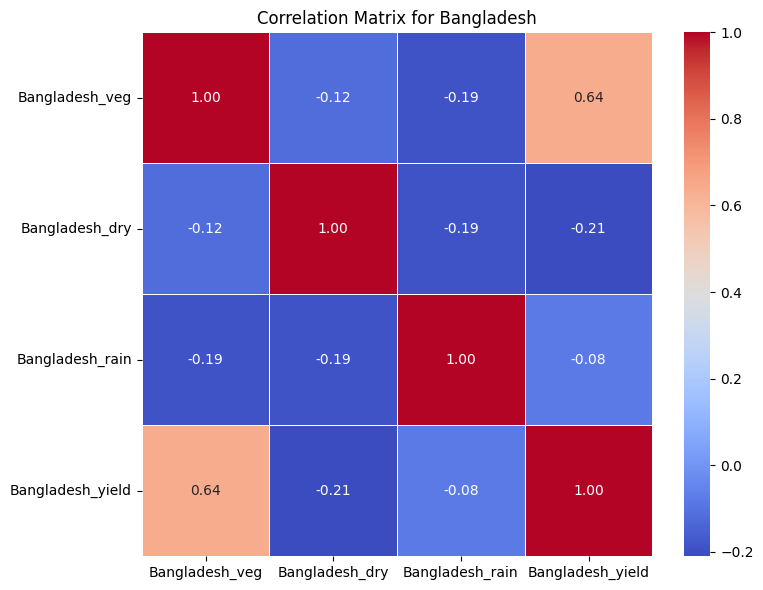

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming merged_df is available from previous steps

# Bangladesh Correlation Matrix
bangladesh_cols = ['Bangladesh_veg', 'Bangladesh_dry', 'Bangladesh_rain', 'Bangladesh_yield']
bangladesh_corr_df = merged_df[bangladesh_cols].dropna()
bangladesh_correlation_matrix = bangladesh_corr_df.corr().round(2)

print("\nCorrelation Matrix for Bangladesh:")
print(bangladesh_correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(bangladesh_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for Bangladesh')
plt.tight_layout()
plt.show()


Correlation Matrix for Costa Rica:
                  Costa Rica_veg  Costa Rica_rain  Costa Rica_yield
Costa Rica_veg              1.00             0.03              0.44
Costa Rica_rain             0.03             1.00              0.30
Costa Rica_yield            0.44             0.30              1.00


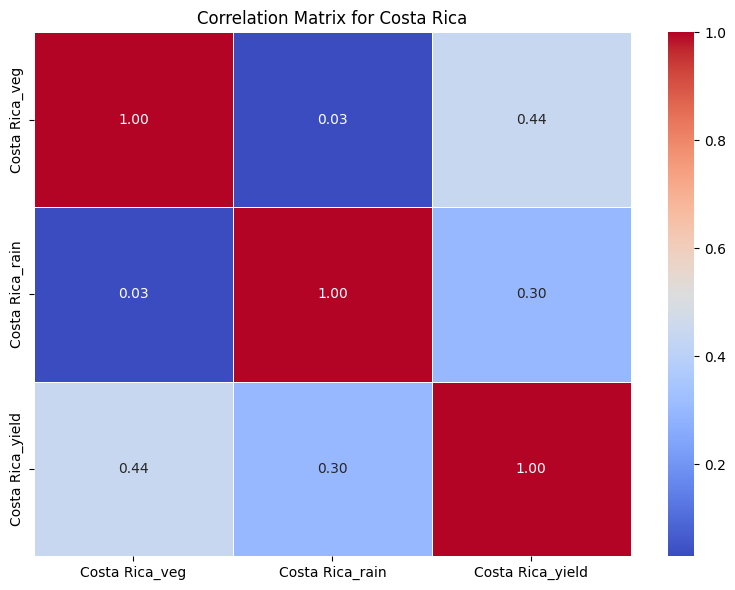

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming merged_df is available from previous steps

# Costa Rica Correlation Matrix
# Exclude 'Costa Rica_dry' as it contains all NaN values
costa_rica_cols = ['Costa Rica_veg', 'Costa Rica_rain', 'Costa Rica_yield']
costa_rica_corr_df = merged_df[costa_rica_cols].dropna()
costa_rica_correlation_matrix = costa_rica_corr_df.corr().round(2)

print("\nCorrelation Matrix for Costa Rica:")
print(costa_rica_correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(costa_rica_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for Costa Rica')
plt.tight_layout()
plt.show()


Correlation Matrix for Namibia:
               Namibia_veg  Namibia_dry  Namibia_yield
Namibia_veg           1.00         0.36           0.18
Namibia_dry           0.36         1.00           0.08
Namibia_yield         0.18         0.08           1.00


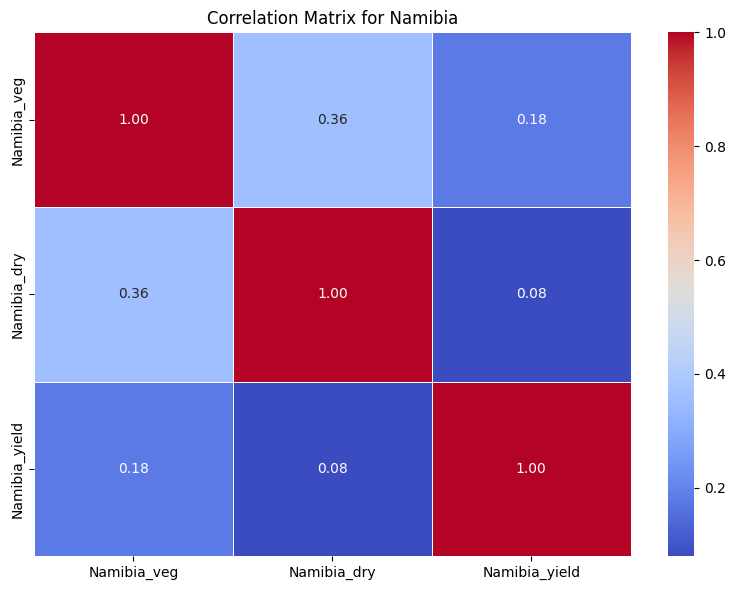

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming merged_df is available from previous steps

# Namibia Correlation Matrix
# Exclude 'Namibia_rain' as it contains all NaN values
namibia_cols = ['Namibia_veg', 'Namibia_dry', 'Namibia_yield']
namibia_corr_df = merged_df[namibia_cols].dropna()
namibia_correlation_matrix = namibia_corr_df.corr().round(2)

print("\nCorrelation Matrix for Namibia:")
print(namibia_correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(namibia_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for Namibia')
plt.tight_layout()
plt.show()